### SETUP AND ENVIRONMENT

In [ ]:
!pip install -q torchvision ultralytics pycocotools gpustat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

print('Using device:', device)

if device.type == 'cuda':
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Device properties:", torch.cuda.get_device_properties(0))

torch.manual_seed(42)


Using device: cuda
Device name:  NVIDIA A100-SXM4-40GB
Device properties: _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40506MB, multi_processor_count=108, uuid=e3dc4bff-4164-58bd-ce9f-cec689fea3e7, pci_bus_id=0, pci_device_id=4, pci_domain_id=0, L2_cache_size=40MB)


### IMPORTS and MOUNT GOOGLE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from urllib.request import urlretrieve
import zipfile
import glob
import json
import shutil
from tqdm import tqdm
import random
from PIL import Image

import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn, FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### DOWNLOAD KITTI DATASET

In [ ]:
print("\n Downloading KITTI Dataset...")

os.makedirs("kitti_data", exist_ok=True)
os.chdir("kitti_data")

kitti_urls = {
    "images": "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip",
    "labels": "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip",
}

def download_and_unzip(name, url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        print(f"Downloading {name}...")
        urlretrieve(url, filename)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        print(f"Extracting {name}...")
        zip_ref.extractall()

for name, url in kitti_urls.items():
    download_and_unzip(name, url)

os.chdir("..")
print(" KITTI data downloaded and extracted.")


Extracting images...
Extracting labels...
 KITTI data downloaded and extracted.


### LOAD WAYMO DATASET

In [ ]:
print("\n Loading Waymo Dataset from Google Drive")

WAYMO_ZIP_PATH = "/content/gdrive/MyDrive/ias project/images.zip"
WAYMO_JSON_PATH = "/content/gdrive/MyDrive/ias project/annotations.json"

os.makedirs("waymo_data", exist_ok=True)

print(" Extracting Waymo images...")
with zipfile.ZipFile(WAYMO_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall("waymo_data")

# Find Waymo image directory
waymo_img_dir = None
for root, dirs, files in os.walk("waymo_data"):
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(image_files) > 100:
        waymo_img_dir = root
        print(f" Found Waymo images in: {waymo_img_dir}")
        break

shutil.copy(WAYMO_JSON_PATH, "waymo_data/annotations.json")

# Load Waymo annotations
with open("waymo_data/annotations.json", 'r') as f:
    waymo_data = json.load(f)

print(f" Waymo: {len(waymo_data['images'])} images")


 Loading Waymo Dataset from Google Drive
 Extracting Waymo images...
 Found Waymo images in: waymo_data/images
 Waymo: 10000 images


#### DEFINE UNIFIED CATEGORIES

In [ ]:
# ============================================
# UNIFIED CATEGORIES AND MAPPINGS
# ============================================
UNIFIED_CATEGORIES = [
    {"id": 1, "name": "vehicle"},
    {"id": 2, "name": "pedestrian"},
    {"id": 3, "name": "cyclist"},
]

# KITTI to unified mapping
kitti_to_unified = {
    'Car': 'vehicle',
    'Van': 'vehicle',
    'Truck': 'vehicle',
    'Pedestrian': 'pedestrian',
    'Person_sitting': 'pedestrian',
    'Cyclist': 'cyclist',
}

# WAYMO to unified mapping - CORRECTED
waymo_to_unified = {
    'Vehicle': 'vehicle',       # Match actual Waymo category names
    'Pedestrian': 'pedestrian',
    'Cyclist': 'cyclist',
    # 'Sign' is not mapped (will be filtered out)
}

unified_name_to_id = {cat['name']: cat['id'] for cat in UNIFIED_CATEGORIES}

print(f"Unified Categories: {UNIFIED_CATEGORIES}")


Unified Categories: [{'id': 1, 'name': 'vehicle'}, {'id': 2, 'name': 'pedestrian'}, {'id': 3, 'name': 'cyclist'}]


### CONVERT KITTI TO COCO FORMAT

In [ ]:
def read_label_file(filepath):
    labels = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            obj = {
                'type': parts[0],
                'truncated': float(parts[1]),
                'occluded': int(parts[2]),
                'alpha': float(parts[3]),
                'bbox': np.array([float(x) for x in parts[4:8]]),
                'dimensions': np.array([float(x) for x in parts[8:11]]),
                'location': np.array([float(x) for x in parts[11:14]]),
                'rotation_y': float(parts[14])
            }
            labels.append(obj)
    return labels

def convert_kitti_to_coco(kitti_dir, max_images=None):

    image_dir = os.path.join(kitti_dir, "training/image_2")
    label_dir = os.path.join(kitti_dir, "training/label_2")

    images = []
    annotations = []
    img_id = 1
    ann_id = 1

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    if max_images:
        image_files = image_files[:max_images]

    for fname in tqdm(image_files, desc="Converting KITTI"):
        img_path = os.path.join(image_dir, fname)
        lbl_path = os.path.join(label_dir, fname.replace(".png", ".txt"))

        img = Image.open(img_path)
        w, h = img.size

        images.append({
            "id": img_id,
            "file_name": fname,
            "width": w,
            "height": h,
            "dataset": "kitti"
        })

        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    cls = parts[0]
                    if cls not in kitti_to_unified:
                        continue

                    unified_name = kitti_to_unified[cls]
                    x1, y1, x2, y2 = map(float, parts[4:8])
                    bbox_w, bbox_h = x2 - x1, y2 - y1

                    annotations.append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_name": unified_name,
                        "bbox": [x1, y1, bbox_w, bbox_h],
                        "area": bbox_w * bbox_h,
                        "iscrowd": 0
                    })
                    ann_id += 1

        img_id += 1

    return images, annotations

print("\n Converting KITTI to COCO format...")
kitti_images, kitti_annotations = convert_kitti_to_coco("kitti_data", max_images=8000)
print(f" KITTI: {len(kitti_images)} images, {len(kitti_annotations)} annotations")


 Converting KITTI to COCO format...


Converting KITTI: 100%|██████████| 7481/7481 [00:01<00:00, 7057.53it/s]

 KITTI: 7481 images, 39086 annotations


### CONVERT WAYMO TO COCO FORMAT

In [ ]:
def create_waymo_dataset(waymo_data, waymo_img_dir, max_images=None):
    """Create Waymo-only dataset in COCO format - FIXED VERSION"""
    print("\nCreating Waymo dataset in COCO format")

    if max_images:
        print(f"TESTING MODE: Using only {max_images} Waymo images")

    os.makedirs("waymo_dataset/images", exist_ok=True)
    os.makedirs("waymo_dataset/annotations", exist_ok=True)

    # Build Waymo category mapping
    waymo_cat_id_to_name = {cat['id']: cat['name'] for cat in waymo_data['categories']}
    print(f"Waymo categories: {waymo_cat_id_to_name}")

    # First pass: identify images with valid annotations
    waymo_images_with_anns = set()

    for ann in waymo_data['annotations']:
        waymo_cat_name = waymo_cat_id_to_name.get(ann['category_id'], 'unknown')
        unified_name = waymo_to_unified.get(waymo_cat_name)

        if unified_name and unified_name in unified_name_to_id:
            waymo_images_with_anns.add(ann['image_id'])

    print(f"Waymo images with valid annotations: {len(waymo_images_with_anns)}")

    # Limit images if requested (only those with annotations)
    images_with_anns = [img for img in waymo_data['images']
                       if img['id'] in waymo_images_with_anns]

    if max_images:
        waymo_images_to_process = images_with_anns[:max_images]
        print(f"Limited to {len(waymo_images_to_process)} images")
    else:
        waymo_images_to_process = images_with_anns

    # Second pass: copy images
    waymo_imgs_final = []

    for img in tqdm(waymo_images_to_process, desc="Processing Waymo images"):
        filename = img['file_name']

        # Clean filename
        if filename.startswith('images/'):
            filename = filename[7:]
        filename = os.path.basename(filename)

        src = os.path.join(waymo_img_dir, filename)
        if not os.path.exists(src):
            continue

        dst = f"waymo_dataset/images/{filename}"
        shutil.copy(src, dst)

        waymo_imgs_final.append({
            "id": img['id'],
            "file_name": filename,
            "width": img.get('width', 1920),
            "height": img.get('height', 1280),
            "dataset": "waymo"
        })

    print(f"Copied {len(waymo_imgs_final)} Waymo images")

    # Third pass: process annotations
    final_valid_ids = {img['id'] for img in waymo_imgs_final}
    waymo_anns_final = []
    ann_id = 1

    for ann in waymo_data['annotations']:
        if ann['image_id'] not in final_valid_ids:
            continue

        waymo_cat_name = waymo_cat_id_to_name.get(ann['category_id'], 'unknown')
        unified_name = waymo_to_unified.get(waymo_cat_name)

        if unified_name and unified_name in unified_name_to_id:
            waymo_anns_final.append({
                "id": ann_id,
                "image_id": ann['image_id'],
                "category_id": unified_name_to_id[unified_name],
                "bbox": ann['bbox'],
                "area": ann.get('area', ann['bbox'][2] * ann['bbox'][3]),
                "iscrowd": 0
            })
            ann_id += 1

    print(f"Added {len(waymo_anns_final)} annotations")

    # Split train/val
    random.seed(42)
    random.shuffle(waymo_imgs_final)
    split_idx = int(len(waymo_imgs_final) * 0.8)

    train_imgs = waymo_imgs_final[:split_idx]
    val_imgs = waymo_imgs_final[split_idx:]
    train_ids = {img['id'] for img in train_imgs}
    val_ids = {img['id'] for img in val_imgs}

    train_anns = [ann for ann in waymo_anns_final if ann['image_id'] in train_ids]
    val_anns = [ann for ann in waymo_anns_final if ann['image_id'] in val_ids]

    # Save JSONs
    with open("waymo_dataset/annotations/instances_train.json", 'w') as f:
        json.dump({
            "info": {"description": "Waymo only dataset"},
            "images": train_imgs,
            "annotations": train_anns,
            "categories": UNIFIED_CATEGORIES
        }, f)

    with open("waymo_dataset/annotations/instances_val.json", 'w') as f:
        json.dump({
            "info": {"description": "Waymo only dataset"},
            "images": val_imgs,
            "annotations": val_anns,
            "categories": UNIFIED_CATEGORIES
        }, f)

    print(f"\nWaymo dataset created:")
    print(f"  Train: {len(train_imgs)} images, {len(train_anns)} annotations")
    print(f"  Val: {len(val_imgs)} images, {len(val_anns)} annotations")

    return len(train_imgs), len(val_imgs)


### CREATE Waymo + KITTI DATASET

In [ ]:
def create_mixed_dataset(kitti_imgs, kitti_anns, waymo_data, waymo_img_dir, waymo_max_images=None):
    """Create mixed dataset - FIXED VERSION"""
    print("\nCreating Mixed (KITTI + Waymo) dataset...")

    os.makedirs("mixed_dataset/images", exist_ok=True)
    os.makedirs("mixed_dataset/annotations", exist_ok=True)

    merged_images = []
    merged_annotations = []
    ann_id = 1

    # Process KITTI
    print("Processing KITTI...")
    for img in tqdm(kitti_imgs, desc="Copying KITTI"):
        src = f"kitti_data/training/image_2/{img['file_name']}"
        if not os.path.exists(src):
            continue
        dst = f"mixed_dataset/images/kitti_{img['file_name']}"
        shutil.copy(src, dst)

        merged_images.append({
            "id": img['id'],
            "file_name": f"kitti_{img['file_name']}",
            "width": img['width'],
            "height": img['height'],
            "dataset": "kitti"
        })

    # Add KITTI annotations
    for ann in kitti_anns:
        if ann['category_name'] in unified_name_to_id:
            merged_annotations.append({
                "id": ann_id,
                "image_id": ann['image_id'],
                "category_id": unified_name_to_id[ann['category_name']],
                "bbox": ann['bbox'],
                "area": ann['area'],
                "iscrowd": 0
            })
            ann_id += 1

    img_id_offset = len(kitti_imgs)

    # Process Waymo
    print("Processing Waymo...")
    waymo_cat_id_to_name = {cat['id']: cat['name'] for cat in waymo_data['categories']}

    # Find images with valid annotations
    waymo_images_with_anns = set()
    for ann in waymo_data['annotations']:
        waymo_cat_name = waymo_cat_id_to_name.get(ann['category_id'], 'unknown')
        unified_name = waymo_to_unified.get(waymo_cat_name)
        if unified_name and unified_name in unified_name_to_id:
            waymo_images_with_anns.add(ann['image_id'])

    # Limit Waymo images if requested
    images_with_anns = [img for img in waymo_data['images']
                       if img['id'] in waymo_images_with_anns]

    if waymo_max_images:
        waymo_images_to_process = images_with_anns[:waymo_max_images]
        print(f"TESTING MODE: Using only {waymo_max_images} Waymo images")
    else:
        waymo_images_to_process = images_with_anns

    waymo_img_id_mapping = {}

    for img in tqdm(waymo_images_to_process, desc="Copying Waymo"):
        filename = img['file_name']
        if filename.startswith('images/'):
            filename = filename[7:]
        filename = os.path.basename(filename)

        src = os.path.join(waymo_img_dir, filename)
        if not os.path.exists(src):
            continue

        new_id = img['id'] + img_id_offset
        waymo_img_id_mapping[img['id']] = new_id

        dst = f"mixed_dataset/images/waymo_{filename}"
        shutil.copy(src, dst)

        merged_images.append({
            "id": new_id,
            "file_name": f"waymo_{filename}",
            "width": img.get('width', 1920),
            "height": img.get('height', 1280),
            "dataset": "waymo"
        })

    # Add Waymo annotations
    for ann in waymo_data['annotations']:
        if ann['image_id'] not in waymo_img_id_mapping:
            continue

        waymo_cat_name = waymo_cat_id_to_name.get(ann['category_id'], 'unknown')
        unified_name = waymo_to_unified.get(waymo_cat_name)

        if unified_name and unified_name in unified_name_to_id:
            merged_annotations.append({
                "id": ann_id,
                "image_id": waymo_img_id_mapping[ann['image_id']],
                "category_id": unified_name_to_id[unified_name],
                "bbox": ann['bbox'],
                "area": ann.get('area', ann['bbox'][2] * ann['bbox'][3]),
                "iscrowd": 0
            })
            ann_id += 1

    # Save merged dataset
    merged_coco = {
        "info": {"description": "Mixed KITTI + Waymo dataset"},
        "images": merged_images,
        "annotations": merged_annotations,
        "categories": UNIFIED_CATEGORIES
    }

    with open("mixed_dataset/annotations/instances_all.json", 'w') as f:
        json.dump(merged_coco, f)

    # Create train/val split
    random.seed(42)
    random.shuffle(merged_images)
    split_idx = int(len(merged_images) * 0.8)

    train_imgs = merged_images[:split_idx]
    val_imgs = merged_images[split_idx:]
    train_ids = {img['id'] for img in train_imgs}
    val_ids = {img['id'] for img in val_imgs}

    train_anns = [ann for ann in merged_annotations if ann['image_id'] in train_ids]
    val_anns = [ann for ann in merged_annotations if ann['image_id'] in val_ids]

    with open("mixed_dataset/annotations/instances_train.json", 'w') as f:
        json.dump({
            "info": merged_coco['info'],
            "images": train_imgs,
            "annotations": train_anns,
            "categories": UNIFIED_CATEGORIES
        }, f)

    with open("mixed_dataset/annotations/instances_val.json", 'w') as f:
        json.dump({
            "info": merged_coco['info'],
            "images": val_imgs,
            "annotations": val_anns,
            "categories": UNIFIED_CATEGORIES
        }, f)

    print(f"Mixed dataset: {len(train_imgs)} train, {len(val_imgs)} val")
    print(f"Total annotations: {len(train_anns)} train, {len(val_anns)} val")

    return len(train_imgs), len(val_imgs)


### CREATE YOLO FORMAT DATASETS

In [ ]:
def create_yolo_dataset(train_json, val_json, img_dir, output_dir):
    """Convert COCO to YOLO format - FIXED"""
    print(f"\nCreating YOLO dataset: {output_dir}")

    os.makedirs(f"{output_dir}/images/train", exist_ok=True)
    os.makedirs(f"{output_dir}/images/val", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/train", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/val", exist_ok=True)

    def process_split(json_file, img_dir, output_dir, split_name):
        with open(json_file, 'r') as f:
            data = json.load(f)

        images_with_labels = 0

        for img in tqdm(data['images'], desc=f"Converting {split_name}"):
            # Get annotations for this image
            img_anns = [ann for ann in data['annotations'] if ann['image_id'] == img['id']]

            if not img_anns:
                continue  # Skip images without annotations

            src = os.path.join(img_dir, img['file_name'])
            if not os.path.exists(src):
                continue

            # Copy image
            dst = f"{output_dir}/images/{split_name}/{img['file_name']}"
            shutil.copy(src, dst)

            # Convert annotations to YOLO format
            yolo_lines = []
            for ann in img_anns:
                x, y, w, h = ann['bbox']
                img_w, img_h = img['width'], img['height']

                if w <= 0 or h <= 0:
                    continue

                # YOLO format: class x_center y_center width height (normalized)
                x_center = (x + w/2) / img_w
                y_center = (y + h/2) / img_h
                norm_w = w / img_w
                norm_h = h / img_h

                # Clip to valid range
                x_center = max(0, min(1, x_center))
                y_center = max(0, min(1, y_center))
                norm_w = max(0, min(1, norm_w))
                norm_h = max(0, min(1, norm_h))

                yolo_class = ann['category_id'] - 1  # 0-indexed
                yolo_lines.append(f"{yolo_class} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}")

            # Save label file
            if yolo_lines:
                label_file = f"{output_dir}/labels/{split_name}/{os.path.splitext(img['file_name'])[0]}.txt"
                with open(label_file, 'w') as f:
                    f.write("\n".join(yolo_lines))
                images_with_labels += 1

        print(f"  {split_name}: {images_with_labels} images with labels")
        return images_with_labels

    # Process both splits
    train_count = process_split(train_json, img_dir, output_dir, "train")
    val_count = process_split(val_json, img_dir, output_dir, "val")

    # Create data.yaml
    with open(f"{output_dir}/data.yaml", 'w') as f:
        f.write(f"""path: {os.path.abspath(output_dir)}
train: images/train
val: images/val

names:
  0: vehicle
  1: pedestrian
  2: cyclist
""")

    print(f"YOLO dataset created: {output_dir}")
    return train_count, val_count


In [ ]:
# Delete old datasets to start fresh
import shutil
for dataset in ["waymo_dataset", "mixed_dataset", "waymo_yolo", "mixed_yolo"]:
    if os.path.exists(dataset):
        shutil.rmtree(dataset)

# Create Waymo dataset
waymo_train, waymo_val = create_waymo_dataset(
    waymo_data,
    waymo_img_dir,
    max_images=8000
)

# Create Mixed dataset
mixed_train, mixed_val = create_mixed_dataset(
    kitti_images,
    kitti_annotations,
    waymo_data,
    waymo_img_dir,
    waymo_max_images=8000
)

# Create YOLO datasets
create_yolo_dataset(
    "waymo_dataset/annotations/instances_train.json",
    "waymo_dataset/annotations/instances_val.json",
    "waymo_dataset/images",
    "waymo_yolo"
)

create_yolo_dataset(
    "mixed_dataset/annotations/instances_train.json",
    "mixed_dataset/annotations/instances_val.json",
    "mixed_dataset/images",
    "mixed_yolo"
)

print("\nAll datasets created successfully!")



Creating Waymo dataset in COCO format
TESTING MODE: Using only 8000 Waymo images
Waymo categories: {1: 'Vehicle', 2: 'Pedestrian', 3: 'Cyclist', 4: 'Sign'}
Waymo images with valid annotations: 9761
Limited to 8000 images


Processing Waymo images: 100%|██████████| 8000/8000 [00:01<00:00, 4334.91it/s]


Copied 8000 Waymo images
Added 175395 annotations

Waymo dataset created:
  Train: 6400 images, 140202 annotations
  Val: 1600 images, 35193 annotations

Creating Mixed (KITTI + Waymo) dataset...
Processing KITTI...


Copying KITTI: 100%|██████████| 7481/7481 [00:15<00:00, 481.02it/s]


Processing Waymo...
TESTING MODE: Using only 8000 Waymo images


Copying Waymo: 100%|██████████| 8000/8000 [00:06<00:00, 1246.53it/s]


Mixed dataset: 12384 train, 3097 val
Total annotations: 171369 train, 43112 val

Creating YOLO dataset: waymo_yolo


Converting train: 100%|██████████| 6400/6400 [01:30<00:00, 71.06it/s]


  train: 6400 images with labels


Converting val: 100%|██████████| 1600/1600 [00:04<00:00, 329.41it/s]


  val: 1600 images with labels
YOLO dataset created: waymo_yolo

Creating YOLO dataset: mixed_yolo


Converting train: 100%|██████████| 12384/12384 [03:06<00:00, 66.42it/s]


  train: 12384 images with labels


Converting val: 100%|██████████| 3097/3097 [00:11<00:00, 263.66it/s]

  val: 3097 images with labels
YOLO dataset created: mixed_yolo

All datasets created successfully!


### RCNN MODEL ARCHITECTURE MODIFICATION

In [ ]:

# Replace classification head with custom FastRCNNPredictor for 3+1 unified categories (vehicle, pedestrian, cyclist + background)
def create_fasterrcnn_model(num_classes):

    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 4  # 3 unified classes + background

print("\n Model Architecture Modification:")
print(f"   Modified Faster R-CNN for {num_classes} classes")
print(f"   Categories: {[cat['name'] for cat in UNIFIED_CATEGORIES]} + background")


 Model Architecture Modification:
   Modified Faster R-CNN for 4 classes
   Categories: ['vehicle', 'pedestrian', 'cyclist'] + background


### Training Function for FASTER R-CNN

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

def train_faster_rcnn(model, data_dir, ann_file, num_epochs=10, batch_size=2, lr=5e-4, model_name="model"):

    def transform_fn(img, target):
        return F.to_tensor(img), target

    dataset = CocoDetection(root=f"{data_dir}/images", annFile=ann_file, transforms=transform_fn)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    model.train()

    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f" Epoch {epoch + 1}/{num_epochs}")
        print(f"{'='*60}")

        epoch_loss = 0.0
        batch_count = 0

        for images, targets in tqdm(dataloader, desc=f"Training"):
            images = [img.to(device) for img in images]

            converted_targets = []
            for ann_list in targets:
                boxes = []
                labels = []
                for ann in ann_list:
                    bbox = ann["bbox"]
                    x1, y1, w, h = bbox
                    boxes.append([x1, y1, x1 + w, y1 + h])
                    labels.append(ann["category_id"])

                if boxes:
                    boxes = torch.as_tensor(boxes, dtype=torch.float32)
                    labels = torch.as_tensor(labels, dtype=torch.int64)
                else:
                    boxes = torch.zeros((0, 4), dtype=torch.float32)
                    labels = torch.zeros((0,), dtype=torch.int64)

                converted_targets.append({
                    "boxes": boxes.to(device),
                    "labels": labels.to(device)
                })

            loss_dict = model(images, converted_targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()
            batch_count += 1

        avg_loss = epoch_loss / batch_count
        print(f" Epoch {epoch + 1} finished. Average Loss: {avg_loss:.4f}")

        lr_scheduler.step()

        checkpoint_path = f"{model_name}_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f" Saved model checkpoint to {checkpoint_path}")

    print(" Training completed!")
    return model


### TRAIN FASTER R-CNN ON WAYMO

In [ ]:
print("\n" + "="*70)
print(" SCENARIO 1: TRAINING FASTER R-CNN ON WAYMO-ONLY")
print("="*70)

frcnn_waymo = create_fasterrcnn_model(num_classes).to(device)
frcnn_waymo = train_faster_rcnn(
    frcnn_waymo,
    "waymo_dataset",
    "waymo_dataset/annotations/instances_train.json",
    num_epochs=10,
    batch_size=2,
    lr=5e-4,
    model_name="fasterrcnn_waymo"
)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 SCENARIO 1: TRAINING FASTER R-CNN ON WAYMO-ONLY
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 238MB/s]


loading annotations into memory...
Done (t=0.48s)
creating index...
index created!

 Epoch 1/10


Training: 100%|██████████| 3200/3200 [06:03<00:00,  8.81it/s]


 Epoch 1 finished. Average Loss: 0.8440
 Saved model checkpoint to fasterrcnn_waymo_epoch_1.pth

 Epoch 2/10


Training: 100%|██████████| 3200/3200 [06:01<00:00,  8.85it/s]


 Epoch 2 finished. Average Loss: 0.7271
 Saved model checkpoint to fasterrcnn_waymo_epoch_2.pth

 Epoch 3/10


Training: 100%|██████████| 3200/3200 [05:59<00:00,  8.89it/s]


 Epoch 3 finished. Average Loss: 0.6758
 Saved model checkpoint to fasterrcnn_waymo_epoch_3.pth

 Epoch 4/10


Training: 100%|██████████| 3200/3200 [05:59<00:00,  8.90it/s]


 Epoch 4 finished. Average Loss: 0.6288
 Saved model checkpoint to fasterrcnn_waymo_epoch_4.pth

 Epoch 5/10


Training: 100%|██████████| 3200/3200 [05:59<00:00,  8.91it/s]


 Epoch 5 finished. Average Loss: 0.6226
 Saved model checkpoint to fasterrcnn_waymo_epoch_5.pth

 Epoch 6/10


Training: 100%|██████████| 3200/3200 [05:58<00:00,  8.92it/s]


 Epoch 6 finished. Average Loss: 0.6174
 Saved model checkpoint to fasterrcnn_waymo_epoch_6.pth

 Epoch 7/10


Training: 100%|██████████| 3200/3200 [05:59<00:00,  8.91it/s]


 Epoch 7 finished. Average Loss: 0.6108
 Saved model checkpoint to fasterrcnn_waymo_epoch_7.pth

 Epoch 8/10


Training: 100%|██████████| 3200/3200 [06:01<00:00,  8.86it/s]


 Epoch 8 finished. Average Loss: 0.6109
 Saved model checkpoint to fasterrcnn_waymo_epoch_8.pth

 Epoch 9/10


Training: 100%|██████████| 3200/3200 [06:00<00:00,  8.88it/s]


 Epoch 9 finished. Average Loss: 0.6104
 Saved model checkpoint to fasterrcnn_waymo_epoch_9.pth

 Epoch 10/10


Training: 100%|██████████| 3200/3200 [06:00<00:00,  8.88it/s]


 Epoch 10 finished. Average Loss: 0.6099
 Saved model checkpoint to fasterrcnn_waymo_epoch_10.pth
 Training completed!


### TRAIN FASTER R-CNN ON MIXED DATASET

In [ ]:
print("\n" + "="*70)
print(" SCENARIO 2: TRAINING FASTER R-CNN ON MIXED DATASET (KITTI + WAYMO)")
print("="*70)

frcnn_mixed = create_fasterrcnn_model(num_classes).to(device)
frcnn_mixed = train_faster_rcnn(
    frcnn_mixed,
    "mixed_dataset",
    "mixed_dataset/annotations/instances_train.json",
    num_epochs=10,
    batch_size=2,
    lr=5e-4,
    model_name="fasterrcnn_mixed"
)



 SCENARIO 2: TRAINING FASTER R-CNN ON MIXED DATASET (KITTI + WAYMO)
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!

 Epoch 1/10


Training: 100%|██████████| 6192/6192 [10:16<00:00, 10.04it/s]


 Epoch 1 finished. Average Loss: 0.6282
 Saved model checkpoint to fasterrcnn_mixed_epoch_1.pth

 Epoch 2/10


Training: 100%|██████████| 6192/6192 [10:17<00:00, 10.02it/s]


 Epoch 2 finished. Average Loss: 0.5356
 Saved model checkpoint to fasterrcnn_mixed_epoch_2.pth

 Epoch 3/10


Training: 100%|██████████| 6192/6192 [10:17<00:00, 10.03it/s]


 Epoch 3 finished. Average Loss: 0.4957
 Saved model checkpoint to fasterrcnn_mixed_epoch_3.pth

 Epoch 4/10


Training: 100%|██████████| 6192/6192 [10:16<00:00, 10.05it/s]


 Epoch 4 finished. Average Loss: 0.4558
 Saved model checkpoint to fasterrcnn_mixed_epoch_4.pth

 Epoch 5/10


Training: 100%|██████████| 6192/6192 [10:16<00:00, 10.04it/s]


 Epoch 5 finished. Average Loss: 0.4497
 Saved model checkpoint to fasterrcnn_mixed_epoch_5.pth

 Epoch 6/10


Training: 100%|██████████| 6192/6192 [10:16<00:00, 10.04it/s]


 Epoch 6 finished. Average Loss: 0.4453
 Saved model checkpoint to fasterrcnn_mixed_epoch_6.pth

 Epoch 7/10


Training: 100%|██████████| 6192/6192 [10:17<00:00, 10.02it/s]


 Epoch 7 finished. Average Loss: 0.4399
 Saved model checkpoint to fasterrcnn_mixed_epoch_7.pth

 Epoch 8/10


Training: 100%|██████████| 6192/6192 [10:15<00:00, 10.06it/s]


 Epoch 8 finished. Average Loss: 0.4392
 Saved model checkpoint to fasterrcnn_mixed_epoch_8.pth

 Epoch 9/10


Training: 100%|██████████| 6192/6192 [10:18<00:00, 10.01it/s]


 Epoch 9 finished. Average Loss: 0.4386
 Saved model checkpoint to fasterrcnn_mixed_epoch_9.pth

 Epoch 10/10


Training: 100%|██████████| 6192/6192 [10:18<00:00, 10.01it/s]


 Epoch 10 finished. Average Loss: 0.4385
 Saved model checkpoint to fasterrcnn_mixed_epoch_10.pth
 Training completed!


### TRAIN YOLOV8 ON WAYMO

In [ ]:
print("\n" + "="*70)
print(" SCENARIO 3: TRAINING YOLOV8 ON WAYMO-ONLY")
print("="*70)

yolo_waymo = YOLO("yolov8n.pt")
yolo_waymo.train(data="waymo_yolo/data.yaml", epochs=50, imgsz=640, batch=16, name="yolo_waymo")



 SCENARIO 3: TRAINING YOLOV8 ON WAYMO-ONLY
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=waymo_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_waymo, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3113.0±940.2 MB/s, size: 192.5 KB)
train: Scanning /content/waymo_yolo/labels/train... 6400 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6400/6400 1.4Kit/s 4.5s
train: /content/waymo_yolo/images/train/10664823084372323928_4360_000_4380_000_1_1558019636472421.jpg: 1 duplicate labels removed
train: /content/waymo_yolo/images/train/10723911392655396041_860_000_880_000_1_1559176370876071.jpg: 1 duplicate labels removed
train: /content/waymo_yolo/images/train/11113047206980595400_2560_000_2580_000_1_1557855067047287.jpg: 1 duplicate labels removed
train: /content/waymo_yolo/images/train/11799592541704458019_9828_750_9848_750_1_1506959822827603.jpg: 1 duplicate labels removed
train: New cache created: /content/waymo_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_lim

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/50      4.99G      1.511      1.337      1.051        418        640: 100% ━━━━━━━━━━━━ 400/400 9.6it/s 41.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 6.5it/s 7.7s
                   all       1600      35188      0.636      0.356      0.396       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      5.01G      1.417     0.9582      1.028        608        640: 0% ──────────── 1/400 1.8it/s 0.2s<3:41

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/50      5.36G      1.449     0.9441      1.039        367        640: 100% ━━━━━━━━━━━━ 400/400 10.6it/s 37.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188       0.65      0.344      0.396       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      5.38G      1.434     0.8879       1.01        591        640: 0% ──────────── 1/400 1.8it/s 0.2s<3:43

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/50      5.76G      1.444     0.8906      1.034        525        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.2s
                   all       1600      35188      0.664      0.392      0.447      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      5.78G      1.411     0.8645      1.028        635        640: 0% ──────────── 1/400 1.9it/s 0.2s<3:33

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/50      5.78G      1.397       0.84       1.02        608        640: 100% ━━━━━━━━━━━━ 400/400 10.9it/s 36.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.2s
                   all       1600      35188      0.661      0.403      0.466      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50      5.79G      1.398      0.846       1.04        680        640: 0% ──────────── 1/400 1.9it/s 0.2s<3:31

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/50       6.2G      1.355     0.8003      1.005        366        640: 100% ━━━━━━━━━━━━ 400/400 11.2it/s 35.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.3s
                   all       1600      35188      0.679      0.426      0.475      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50      6.22G      1.292      0.748     0.9745        539        640: 0% ──────────── 1/400 1.9it/s 0.2s<3:25

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/50      6.22G      1.339     0.7792     0.9976        595        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.3s
                   all       1600      35188      0.705      0.428      0.488      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      6.23G      1.253     0.7702     0.9759        387        640: 0% ──────────── 1/400 1.8it/s 0.2s<3:41

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/50      6.24G      1.315     0.7551     0.9898        711        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 7.9it/s 6.3s
                   all       1600      35188      0.699      0.435        0.5       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      6.25G       1.29     0.7361     0.9725        598        640: 0% ──────────── 1/400 1.9it/s 0.2s<3:26

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/50      6.25G       1.29     0.7397     0.9841        595        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.3s
                   all       1600      35188      0.718      0.452      0.515      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      6.27G      1.406     0.7739     0.9987        609        640: 0% ──────────── 1/400 2.0it/s 0.2s<3:23

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/50      6.27G      1.292      0.732     0.9822        676        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 7.9it/s 6.3s
                   all       1600      35188      0.722      0.451      0.519      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      6.29G      1.179     0.6747     0.9669        542        640: 0% ──────────── 1/400 1.9it/s 0.2s<3:34

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/50      6.29G      1.265      0.713      0.974        444        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 7.8it/s 6.4s
                   all       1600      35188      0.726       0.46      0.525      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50       6.3G       1.22     0.6804     0.9533        503        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:18

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/50       6.3G      1.251     0.7038     0.9698        577        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.3s
                   all       1600      35188      0.731      0.464      0.528      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50      6.32G      1.179     0.6582     0.9391        602        640: 0% ──────────── 1/400 1.9it/s 0.2s<3:29

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/50      6.32G      1.234     0.6901     0.9622        596        640: 100% ━━━━━━━━━━━━ 400/400 10.9it/s 36.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.2s
                   all       1600      35188       0.74      0.466      0.536      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      6.34G      1.272     0.6806     0.9824        431        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:19

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/50      6.34G      1.232     0.6874     0.9638        602        640: 100% ━━━━━━━━━━━━ 400/400 11.2it/s 35.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.2s
                   all       1600      35188      0.741      0.466      0.539      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50      6.35G      1.183     0.6787       0.95        558        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:16

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/50      6.35G      1.219     0.6761     0.9602        688        640: 100% ━━━━━━━━━━━━ 400/400 10.9it/s 36.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188      0.737      0.477      0.546      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      6.37G      1.182     0.6693     0.9384        419        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:19

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/50      6.37G      1.213     0.6686     0.9569        399        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188      0.753      0.473      0.553      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      6.39G       1.19     0.6551     0.9471        491        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:16

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/50      6.39G      1.199     0.6607     0.9531        489        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.2it/s 6.1s
                   all       1600      35188      0.751      0.476      0.556      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50      6.41G      1.152     0.6243     0.9304        480        640: 0% ──────────── 1/400 2.0it/s 0.2s<3:20

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/50      6.41G      1.192     0.6559     0.9529        538        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.2it/s 6.1s
                   all       1600      35188      0.757      0.484      0.558      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50      6.42G      1.176      0.669     0.9823        670        640: 0% ──────────── 1/400 1.9it/s 0.2s<3:29

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/50      6.42G      1.181      0.648     0.9482        731        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.3s
                   all       1600      35188      0.759      0.487      0.565      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      6.44G      1.228     0.6618     0.9309        714        640: 0% ──────────── 0/400  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/50      6.44G      1.178     0.6441     0.9453        558        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188       0.75       0.49      0.565      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      6.46G       1.15     0.6343     0.9343        441        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:18

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/50      6.46G      1.172     0.6393     0.9433        500        640: 100% ━━━━━━━━━━━━ 400/400 11.2it/s 35.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.3s
                   all       1600      35188      0.748      0.493      0.567      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50      6.47G      1.165     0.6332     0.9455        641        640: 0% ──────────── 1/400 2.0it/s 0.2s<3:22

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      21/50      6.47G      1.164     0.6346     0.9431        458        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 7.9it/s 6.3s
                   all       1600      35188      0.768      0.491      0.569      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      6.49G      1.221      0.643     0.9672        601        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:18

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      22/50      6.49G      1.155     0.6277     0.9394        642        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 7.9it/s 6.3s
                   all       1600      35188      0.764      0.496      0.571      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      6.51G      1.077     0.6023     0.9221        611        640: 0% ──────────── 1/400 1.8it/s 0.2s<3:44

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      23/50      6.51G      1.152     0.6235     0.9396        485        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 35.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.2s
                   all       1600      35188      0.772        0.5      0.576      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50      6.52G      1.085     0.6172     0.9245        371        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:15

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      24/50      6.53G      1.143     0.6179     0.9347        739        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188      0.772      0.497      0.574      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      6.54G      1.111     0.5862     0.9081        694        640: 0% ──────────── 1/400 2.0it/s 0.2s<3:21

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      25/50      6.54G      1.135     0.6115     0.9322        582        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188      0.765      0.505      0.579      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50      6.56G      1.132     0.6166     0.9145        650        640: 0% ──────────── 1/400 1.8it/s 0.2s<3:41

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      26/50      6.56G      1.132       0.61     0.9312        612        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188      0.767      0.506      0.582      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50      6.58G       1.15      0.621     0.9363        629        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:19

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      27/50      6.58G      1.124     0.6059     0.9294        573        640: 100% ━━━━━━━━━━━━ 400/400 10.9it/s 36.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.2it/s 6.1s
                   all       1600      35188      0.776      0.508      0.583      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      6.59G       1.11     0.6016     0.9117        607        640: 0% ──────────── 1/400 2.0it/s 0.2s<3:20

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      28/50      6.59G      1.128     0.6064     0.9292        405        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 35.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.3it/s 6.0s
                   all       1600      35188      0.777      0.506      0.586      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      6.61G      1.064       0.58      0.898        422        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:18

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      29/50      6.61G      1.116     0.5993     0.9271        527        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.2it/s 6.1s
                   all       1600      35188       0.78       0.51      0.592      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50      6.63G      1.172      0.624     0.9637        791        640: 0% ──────────── 1/400 2.0it/s 0.2s<3:24

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      30/50      6.63G      1.108     0.5934     0.9266        579        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.2s
                   all       1600      35188      0.773      0.512      0.588      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50      6.64G      1.014     0.5674     0.9062        640        640: 0% ──────────── 1/400 1.9it/s 0.2s<3:33

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      31/50      6.65G      1.104     0.5919     0.9228        629        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188       0.78      0.512      0.593      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50      6.66G      1.144     0.6262     0.9203        524        640: 0% ──────────── 1/400 1.8it/s 0.2s<3:41

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      32/50      6.66G      1.105     0.5905     0.9245        596        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.1s
                   all       1600      35188      0.783      0.515      0.596      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50      6.68G      1.016     0.5515     0.9174        516        640: 0% ──────────── 1/400 2.0it/s 0.2s<3:21

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      33/50      6.68G      1.097     0.5829     0.9203        684        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.2s
                   all       1600      35188      0.773       0.52      0.597      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50       6.7G      1.141     0.6175     0.9267        412        640: 0% ──────────── 1/400 1.8it/s 0.2s<3:38

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      34/50       6.7G      1.091     0.5813     0.9212        478        640: 100% ━━━━━━━━━━━━ 400/400 11.1it/s 36.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 7.9it/s 6.3s
                   all       1600      35188      0.785      0.518      0.598      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      6.71G      1.099     0.5901     0.9397        436        640: 0% ──────────── 1/400 2.0it/s 0.2s<3:23

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      35/50      6.71G       1.08     0.5742     0.9166        492        640: 100% ━━━━━━━━━━━━ 400/400 10.9it/s 36.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.2s
                   all       1600      35188      0.781       0.52      0.598      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50      6.73G      1.071     0.5748     0.9225        488        640: 0% ──────────── 1/400 1.8it/s 0.2s<3:44

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      36/50      6.73G      1.074     0.5684     0.9157        600        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.2it/s 6.1s
                   all       1600      35188      0.783      0.522      0.603      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50      6.75G      1.201     0.6299     0.9107        795        640: 0% ──────────── 1/400 1.8it/s 0.2s<3:41

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      37/50      6.75G      1.077     0.5728     0.9152        494        640: 100% ━━━━━━━━━━━━ 400/400 10.9it/s 36.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188      0.788      0.518      0.602      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50      6.76G      1.078     0.5841     0.9043        614        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:18

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      38/50      6.76G      1.078     0.5716     0.9151        557        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.3it/s 6.0s
                   all       1600      35188      0.788      0.523      0.602      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/50      6.78G      1.105     0.5688     0.9045        479        640: 0% ──────────── 1/400 1.8it/s 0.2s<3:42

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      39/50      6.78G      1.061     0.5608     0.9109        742        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.3it/s 6.0s
                   all       1600      35188      0.791      0.526      0.607      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50       6.8G      1.098      0.578     0.9173        631        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:19

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      40/50       6.8G      1.065     0.5642     0.9115        527        640: 100% ━━━━━━━━━━━━ 400/400 11.0it/s 36.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188      0.793      0.528      0.609      0.367
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50      6.81G      1.117     0.5791     0.8943        415        640: 0% ──────────── 0/400  0.6s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      41/50      6.81G      1.063     0.5521     0.9064        270        640: 100% ━━━━━━━━━━━━ 400/400 10.9it/s 36.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.3s
                   all       1600      35188        0.8      0.519      0.604      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50      6.83G     0.9817     0.5153     0.8964        310        640: 0% ──────────── 1/400 2.1it/s 0.1s<3:12

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      42/50      6.83G      1.049     0.5448     0.9033        316        640: 100% ━━━━━━━━━━━━ 400/400 11.4it/s 35.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188      0.794      0.525      0.609      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50      6.85G      1.068     0.5485     0.8787        253        640: 0% ──────────── 1/400 2.0it/s 0.2s<3:22

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      43/50      6.85G      1.041     0.5402     0.9002        233        640: 100% ━━━━━━━━━━━━ 400/400 11.5it/s 34.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.3s
                   all       1600      35188      0.794      0.526      0.609      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50      6.87G       1.06     0.5371     0.9138        290        640: 0% ──────────── 1/400 1.9it/s 0.2s<3:29

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      44/50      6.87G      1.033     0.5359     0.8992        342        640: 100% ━━━━━━━━━━━━ 400/400 11.5it/s 34.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.3s
                   all       1600      35188      0.791      0.526       0.61       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/50      6.88G      1.128     0.5901     0.8961        388        640: 0% ──────────── 1/400 2.1it/s 0.1s<3:14

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      45/50      6.88G      1.034      0.535     0.8982        334        640: 100% ━━━━━━━━━━━━ 400/400 11.5it/s 34.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.2s
                   all       1600      35188      0.797      0.527      0.612       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/50       6.9G      1.059     0.5589     0.9121        344        640: 0% ──────────── 1/400 2.1it/s 0.1s<3:14

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      46/50       6.9G      1.025     0.5297     0.8979        313        640: 100% ━━━━━━━━━━━━ 400/400 11.6it/s 34.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 7.9it/s 6.3s
                   all       1600      35188      0.793      0.528      0.613      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50      6.92G      1.013     0.5373     0.8802        307        640: 0% ──────────── 1/400 1.8it/s 0.2s<3:43

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      47/50      6.92G      1.023     0.5288     0.8959        354        640: 100% ━━━━━━━━━━━━ 400/400 11.3it/s 35.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.2s
                   all       1600      35188      0.796      0.528      0.614      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50      6.93G      1.061     0.5454     0.8974        291        640: 0% ──────────── 1/400 2.0it/s 0.1s<3:16

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      48/50      6.94G      1.016     0.5236     0.8921        333        640: 100% ━━━━━━━━━━━━ 400/400 11.6it/s 34.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188      0.791      0.535      0.617      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/50      6.95G      1.006     0.5354     0.9121        332        640: 0% ──────────── 1/400 2.0it/s 0.2s<3:23

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      49/50      6.95G      1.012     0.5227     0.8924        405        640: 100% ━━━━━━━━━━━━ 400/400 11.4it/s 34.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.0it/s 6.3s
                   all       1600      35188      0.796      0.534      0.617      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/50      6.97G      1.025     0.5464     0.8959        338        640: 0% ──────────── 1/400 2.1it/s 0.1s<3:12

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      50/50      6.97G      1.009     0.5196     0.8919        323        640: 100% ━━━━━━━━━━━━ 400/400 11.6it/s 34.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.1it/s 6.2s
                   all       1600      35188      0.789      0.536      0.617      0.376

50 epochs completed in 0.594 hours.
Optimizer stripped from /content/runs/detect/yolo_waymo/weights/last.pt, 6.2MB
Optimizer stripped from /content/runs/detect/yolo_waymo/weights/best.pt, 6.2MB

Validating /content/runs/detect/yolo_waymo/weights/best.pt...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 4.4it/s 11.4s
                   all       1600      35188       0.79      0.537      0.617      0.376
             

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x785037b76d20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

### TRAIN YOLOV8 ON MIXED DATASET

In [ ]:

print("\n" + "="*70)
print(" SCENARIO 4: TRAINING YOLOV8 ON MIXED DATASET (KITTI + WAYMO)")
print("="*70)

yolo_mixed = YOLO("yolov8n.pt")
yolo_mixed.train(data="mixed_yolo/data.yaml", epochs=50, imgsz=640, batch=16, name="yolo_mixed")


 SCENARIO 4: TRAINING YOLOV8 ON MIXED DATASET (KITTI + WAYMO)
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=mixed_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_mixed2, nbs=64, nms=False, opset=None, optimize=False, optimizer=

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

train: Fast image access ✅ (ping: 0.1±0.2 ms, read: 2878.6±1258.7 MB/s, size: 414.3 KB)
train: Scanning /content/mixed_yolo/labels/train.cache... 12384 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 12384/12384 19.9Mit/s 0.0s
train: /content/mixed_yolo/images/train/waymo_10231929575853664160_1160_000_1180_000_1_1557844363822376.jpg: 1 duplicate labels removed
train: /content/mixed_yolo/images/train/waymo_10625026498155904401_200_000_220_000_1_1558046212025568.jpg: 1 duplicate labels removed
train: /content/mixed_yolo/images/train/waymo_10664823084372323928_4360_000_4380_000_1_1558019635472452.jpg: 1 duplicate labels removed
train: /content/mixed_yolo/images/train/waymo_10664823084372323928_4360_000_4380_000_1_1558019636472421.jpg: 1 duplicate labels removed
train: /content/mixed_yolo/images/train/waymo_10723911392655396041_860_000_880_000_1_1559176370876071.jpg: 1 duplicate labels removed
train: /content/mixed_yolo/images/train/waymo_11799592541704458019_9828_750_9848_750_1_150695

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/50      4.69G      1.461       1.26      1.069        253        640: 100% ━━━━━━━━━━━━ 774/774 9.3it/s 1:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 7.1it/s 13.7s
                   all       3097      43109      0.503      0.338      0.345      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      4.69G       1.48      1.006      1.037        402        640: 0% ──────────── 0/774  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/50      4.69G      1.401     0.9239      1.057        376        640: 100% ━━━━━━━━━━━━ 774/774 10.3it/s 1:15
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 7.8it/s 12.4s
                   all       3097      43109      0.559      0.396      0.407      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      4.69G      1.348     0.8563      1.013        281        640: 0% ──────────── 1/774 1.9it/s 0.2s<6:56

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/50      4.69G      1.369     0.8673      1.048        512        640: 100% ━━━━━━━━━━━━ 774/774 10.4it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.0it/s 12.2s
                   all       3097      43109      0.596      0.384      0.439      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      4.69G      1.342     0.8147      1.008        363        640: 0% ──────────── 0/774  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/50      4.69G      1.337     0.8269      1.035        410        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.0it/s 12.2s
                   all       3097      43109      0.575      0.413      0.444      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50      4.69G      1.295      0.785      1.006        254        640: 0% ──────────── 1/774 1.8it/s 0.2s<7:04

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/50      4.69G      1.305     0.7961      1.025        312        640: 100% ━━━━━━━━━━━━ 774/774 10.6it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 7.7it/s 12.7s
                   all       3097      43109      0.664      0.431       0.48      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50      4.69G      1.296     0.8129      1.029        356        640: 0% ──────────── 1/774 1.7it/s 0.2s<7:25

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/50      4.69G      1.273     0.7663      1.011        271        640: 100% ━━━━━━━━━━━━ 774/774 10.6it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 7.8it/s 12.4s
                   all       3097      43109      0.639      0.461      0.494       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      4.69G      1.323     0.8138      1.021        356        640: 0% ──────────── 1/774 2.0it/s 0.2s<6:32

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/50      4.69G      1.255     0.7479      1.006        246        640: 100% ━━━━━━━━━━━━ 774/774 10.6it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 7.7it/s 12.6s
                   all       3097      43109      0.632       0.48      0.528      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      4.69G      1.195     0.7532     0.9942        323        640: 0% ──────────── 1/774 1.7it/s 0.2s<7:32

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/50      4.69G      1.236     0.7366     0.9993        439        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.0it/s 12.2s
                   all       3097      43109       0.69      0.473      0.541        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      4.69G       1.22     0.7242     0.9885        339        640: 0% ──────────── 1/774 1.8it/s 0.2s<7:21

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/50      4.69G      1.224     0.7202     0.9941        369        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.0it/s 12.1s
                   all       3097      43109      0.711      0.485      0.548       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      4.69G      1.284     0.7355      0.966        464        640: 0% ──────────── 0/774  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/50      4.69G      1.207     0.7082     0.9877        350        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.703      0.482      0.554      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      4.69G      1.193     0.6799     0.9583        620        640: 0% ──────────── 1/774 2.0it/s 0.2s<6:35

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/50      4.69G      1.194      0.697     0.9833        359        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.0it/s 12.1s
                   all       3097      43109      0.737       0.49      0.565      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50      4.69G      1.268     0.6907     0.9782        469        640: 0% ──────────── 0/774  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/50      4.69G      1.185     0.6879     0.9798        471        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 7.9it/s 12.2s
                   all       3097      43109      0.731      0.511      0.572      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      4.69G      1.181     0.6963     0.9843        319        640: 0% ──────────── 1/774 1.9it/s 0.2s<6:38

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/50      4.69G      1.169     0.6765     0.9746        368        640: 100% ━━━━━━━━━━━━ 774/774 10.6it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.0it/s 12.1s
                   all       3097      43109       0.76      0.523      0.591      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50      4.69G      1.114     0.6545     0.9636        325        640: 0% ──────────── 1/774 1.7it/s 0.2s<7:35

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/50      4.69G      1.166     0.6743     0.9729        410        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 11.9s
                   all       3097      43109      0.737      0.529      0.596      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      4.69G      1.159     0.6462     0.9526        289        640: 0% ──────────── 1/774 1.8it/s 0.2s<7:07

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/50      4.69G      1.151     0.6625     0.9679        516        640: 100% ━━━━━━━━━━━━ 774/774 10.6it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.0it/s 12.1s
                   all       3097      43109      0.787       0.52      0.608      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      4.69G      1.082     0.6336     0.9252        342        640: 0% ──────────── 1/774 1.7it/s 0.2s<7:23

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/50      4.69G      1.145      0.658     0.9655        443        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.2it/s 11.9s
                   all       3097      43109      0.767      0.525      0.603      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50      4.69G      1.184     0.6518     0.9428        418        640: 0% ──────────── 1/774 2.0it/s 0.2s<6:35

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/50      4.69G      1.135     0.6484     0.9609        280        640: 100% ━━━━━━━━━━━━ 774/774 10.6it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 7.9it/s 12.3s
                   all       3097      43109      0.787      0.527      0.611      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50      4.69G      1.166     0.6744     0.9726        468        640: 0% ──────────── 1/774 1.6it/s 0.2s<8:08

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/50      4.69G      1.127     0.6429     0.9594        269        640: 100% ━━━━━━━━━━━━ 774/774 10.6it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.765       0.54       0.62      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      4.69G      1.099     0.6252     0.9474        257        640: 0% ──────────── 1/774 1.9it/s 0.2s<6:48

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/50      4.69G       1.12     0.6383     0.9589        436        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.2it/s 11.9s
                   all       3097      43109      0.798      0.528      0.627      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      4.69G      1.193     0.6472     0.9328        337        640: 0% ──────────── 0/774  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/50      4.69G      1.113     0.6338     0.9552        363        640: 100% ━━━━━━━━━━━━ 774/774 10.6it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.3it/s 11.7s
                   all       3097      43109      0.768      0.551      0.631      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50      4.69G      1.185      0.685       0.97        371        640: 0% ──────────── 1/774 1.8it/s 0.2s<7:13

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      21/50      4.69G      1.107     0.6302     0.9531        324        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.2it/s 11.8s
                   all       3097      43109      0.776      0.556      0.633      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      4.69G      1.169     0.6551     0.9329        477        640: 0% ──────────── 0/774  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      22/50      4.69G      1.104     0.6267     0.9528        270        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 7.9it/s 12.3s
                   all       3097      43109      0.786      0.556       0.64      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      4.69G      1.124     0.6529     0.9787        248        640: 0% ──────────── 1/774 1.9it/s 0.2s<6:53

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      23/50      4.69G      1.097     0.6187     0.9486        243        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.3it/s 11.7s
                   all       3097      43109      0.799      0.572      0.655      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50      4.69G      1.119     0.6694     0.9255        267        640: 0% ──────────── 0/774  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      24/50      4.69G      1.091     0.6145     0.9451        497        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.3it/s 11.7s
                   all       3097      43109      0.801       0.56      0.647      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      4.69G      1.129     0.6125     0.9378        521        640: 0% ──────────── 1/774 1.8it/s 0.2s<7:10

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      25/50      4.69G      1.081     0.6095     0.9427        283        640: 100% ━━━━━━━━━━━━ 774/774 10.4it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.3it/s 11.7s
                   all       3097      43109       0.81      0.562      0.652      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50      4.69G      1.077     0.5855     0.9247        416        640: 0% ──────────── 0/774  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      26/50      4.69G      1.077     0.6039     0.9407        373        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.3it/s 11.7s
                   all       3097      43109      0.812       0.56      0.656      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50      4.69G      1.081     0.5761     0.9183        403        640: 0% ──────────── 1/774 1.8it/s 0.2s<7:21

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      27/50      4.69G      1.074     0.6017     0.9406        349        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 7.9it/s 12.2s
                   all       3097      43109      0.791       0.57      0.658      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      4.69G      1.148     0.6116     0.9436        395        640: 0% ──────────── 0/774  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      28/50      4.69G      1.069     0.5994     0.9379        355        640: 100% ━━━━━━━━━━━━ 774/774 10.4it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 11.9s
                   all       3097      43109      0.818      0.553      0.652      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      4.69G       1.02      0.552     0.9185        245        640: 0% ──────────── 1/774 1.9it/s 0.2s<6:37

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      29/50      4.69G      1.059     0.5919      0.935        481        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.802      0.569      0.658      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50      4.69G      1.056     0.6009      0.977        240        640: 0% ──────────── 1/774 1.8it/s 0.2s<7:16

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      30/50      4.69G      1.052     0.5864     0.9316        184        640: 100% ━━━━━━━━━━━━ 774/774 10.6it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.841      0.563      0.663      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50      4.69G      1.082     0.5995     0.9312        423        640: 0% ──────────── 1/774 1.6it/s 0.2s<8:00

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      31/50      4.69G      1.051      0.585     0.9343        373        640: 100% ━━━━━━━━━━━━ 774/774 10.6it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.797      0.577      0.665      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50      4.69G      1.059     0.5962     0.9354        425        640: 0% ──────────── 0/774  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      32/50      4.69G      1.045     0.5824     0.9312        310        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.2it/s 11.9s
                   all       3097      43109      0.833      0.568      0.672      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50      4.69G      1.075     0.5895     0.9204        422        640: 0% ──────────── 1/774 2.0it/s 0.2s<6:30

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      33/50      4.69G      1.042       0.58     0.9301        265        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.803      0.589      0.672      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50      4.69G     0.9889     0.5418     0.9112        361        640: 0% ──────────── 1/774 1.7it/s 0.2s<7:24

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      34/50      4.69G      1.039     0.5753     0.9287        407        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 11.9s
                   all       3097      43109      0.837      0.573      0.673      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      4.69G      1.014     0.5607     0.8996        379        640: 0% ──────────── 1/774 2.0it/s 0.2s<6:36

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      35/50      4.69G      1.031     0.5722     0.9272        384        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.2it/s 11.8s
                   all       3097      43109      0.827      0.586      0.677      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50      4.69G     0.9852      0.546     0.9096        398        640: 0% ──────────── 1/774 1.7it/s 0.2s<7:24

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      36/50      4.69G      1.026     0.5683     0.9267        343        640: 100% ━━━━━━━━━━━━ 774/774 10.6it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.804      0.591      0.678      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50      4.69G     0.9238     0.5317     0.9009        426        640: 0% ──────────── 1/774 1.8it/s 0.2s<7:02

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      37/50      4.69G      1.025     0.5673     0.9254        301        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.822      0.591      0.681      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50      4.69G      1.017     0.5631     0.9148        270        640: 0% ──────────── 1/774 1.6it/s 0.2s<8:03

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      38/50      4.69G      1.016     0.5618     0.9226        471        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 11.9s
                   all       3097      43109      0.831      0.593      0.684      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/50      4.69G      1.026     0.5535     0.9416        402        640: 0% ──────────── 1/774 2.0it/s 0.2s<6:36

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      39/50      4.69G       1.01     0.5571     0.9211        390        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.2it/s 11.9s
                   all       3097      43109      0.818      0.598      0.687      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50      4.69G      1.072      0.578     0.9294        298        640: 0% ──────────── 1/774 1.7it/s 0.2s<7:23

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      40/50      4.69G      1.006     0.5565     0.9222        295        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.3it/s 11.7s
                   all       3097      43109      0.838      0.597      0.687      0.427
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50      4.69G     0.8401     0.4434     0.8698        163        640: 0% ──────────── 0/774  0.5s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      41/50      4.69G      1.007     0.5423     0.9132        215        640: 100% ━━━━━━━━━━━━ 774/774 10.5it/s 1:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.818      0.597      0.682      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50      4.69G      0.936     0.5259     0.9133        161        640: 0% ──────────── 1/774 1.7it/s 0.2s<7:24

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      42/50      4.69G     0.9958     0.5355     0.9095        266        640: 100% ━━━━━━━━━━━━ 774/774 10.8it/s 1:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.833      0.591      0.685      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50      4.69G      1.063     0.5314      0.893        213        640: 0% ──────────── 1/774 2.0it/s 0.2s<6:27

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      43/50      4.69G     0.9874     0.5305      0.907        258        640: 100% ━━━━━━━━━━━━ 774/774 10.8it/s 1:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 11.9s
                   all       3097      43109      0.818      0.599      0.688      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50      4.69G     0.9926     0.5397      0.907        232        640: 0% ──────────── 1/774 1.7it/s 0.2s<7:27

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      44/50      4.69G     0.9825     0.5279     0.9053        164        640: 100% ━━━━━━━━━━━━ 774/774 10.7it/s 1:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.816      0.608      0.691      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/50      4.69G      1.002     0.5635     0.9236        174        640: 0% ──────────── 1/774 2.0it/s 0.2s<6:32

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      45/50      4.69G     0.9782     0.5248     0.9036        153        640: 100% ━━━━━━━━━━━━ 774/774 10.8it/s 1:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.2it/s 11.9s
                   all       3097      43109      0.827      0.599       0.69      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/50      4.69G      0.996     0.5489     0.8946        258        640: 0% ──────────── 0/774  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      46/50      4.69G     0.9714     0.5214     0.9019        230        640: 100% ━━━━━━━━━━━━ 774/774 10.7it/s 1:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.2it/s 11.8s
                   all       3097      43109      0.813      0.611       0.69      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50      4.69G     0.8749     0.4653     0.8928        181        640: 0% ──────────── 1/774 1.7it/s 0.2s<7:26

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      47/50      4.69G     0.9659     0.5171     0.8996        100        640: 100% ━━━━━━━━━━━━ 774/774 10.8it/s 1:11
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.2it/s 11.8s
                   all       3097      43109      0.831      0.598       0.69      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50      4.69G     0.9167     0.4912      0.881        173        640: 0% ──────────── 1/774 1.6it/s 0.2s<7:58

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      48/50      4.69G     0.9611     0.5142      0.899        298        640: 100% ━━━━━━━━━━━━ 774/774 10.8it/s 1:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 11.9s
                   all       3097      43109      0.815      0.606       0.69      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/50      4.69G     0.9423     0.4692      0.858        174        640: 0% ──────────── 1/774 2.0it/s 0.2s<6:33

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      49/50      4.69G     0.9574      0.512     0.8977        183        640: 100% ━━━━━━━━━━━━ 774/774 10.8it/s 1:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.1it/s 12.0s
                   all       3097      43109      0.817      0.605      0.693      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/50      4.69G     0.8982     0.5111     0.8899        185        640: 0% ──────────── 1/774 1.8it/s 0.2s<7:15

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      50/50      4.69G      0.953     0.5097     0.8982        176        640: 100% ━━━━━━━━━━━━ 774/774 10.9it/s 1:11
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 8.2it/s 11.8s
                   all       3097      43109      0.814      0.605      0.691      0.434

50 epochs completed in 1.197 hours.
Optimizer stripped from /content/runs/detect/yolo_mixed2/weights/last.pt, 6.2MB
Optimizer stripped from /content/runs/detect/yolo_mixed2/weights/best.pt, 6.2MB

Validating /content/runs/detect/yolo_mixed2/weights/best.pt...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 6.9it/s 14.1s
                   all       3097      43109       0.81      0.609      0.693      0.435
          

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x784f6f3dfbf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

### EVALUATION FUNCTION FOR FASTER R-CNN

In [ ]:
def evaluate_faster_rcnn(model, coco_json, img_dir, save_file="pred_frcnn.json"):

    model.eval()
    coco_gt = COCO(coco_json)
    img_ids = coco_gt.getImgIds()
    images = coco_gt.loadImgs(img_ids)

    predictions = []

    print(f"\n Evaluating Faster R-CNN on {len(images)} images...")

    for img_data in tqdm(images, desc="Inference"):
        img_id = img_data['id']
        img_path = os.path.join(img_dir, img_data['file_name'])

        if not os.path.exists(img_path):
            continue

        image = Image.open(img_path).convert("RGB")
        img_tensor = F.to_tensor(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)[0]

        for box, score, label in zip(output['boxes'], output['scores'], output['labels']):
            if score < 0.3:
                continue

            x1, y1, x2, y2 = box.tolist()
            w, h = x2 - x1, y2 - y1

            predictions.append({
                "image_id": img_id,
                "category_id": int(label.item()),
                "bbox": [float(x1), float(y1), float(w), float(h)],
                "score": float(score)
            })

    print(f" Generated {len(predictions)} predictions")

    with open(save_file, 'w') as f:
        json.dump(predictions, f)

    if predictions:
        coco_dt = coco_gt.loadRes(save_file)
        coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
        coco_eval.evaluate()
        coco_eval.accumulate()
        print(f"\n FRCNN Evaluation Results:")
        coco_eval.summarize()
        return coco_eval.stats[0]
    else:
        print(" No predictions")
        return 0.0


### EVALUATION FUNCTION FOR YOLOV8

In [ ]:
def evaluate_yolo(model_path, coco_json, img_dir, save_file="pred_yolo.json"):

    model = YOLO(model_path)
    coco_gt = COCO(coco_json)
    img_ids = coco_gt.getImgIds()
    images = coco_gt.loadImgs(img_ids)

    predictions = []

    print(f"\n Evaluating YOLOv8 on {len(images)} images...")

    for img_data in tqdm(images, desc="Inference"):
        img_id = img_data['id']
        img_path = os.path.join(img_dir, img_data['file_name'])

        if not os.path.exists(img_path):
            continue

        results = model(img_path, verbose=False, conf=0.25)[0]

        for box, cls, conf in zip(
            results.boxes.xyxy.cpu().numpy(),
            results.boxes.cls.cpu().numpy(),
            results.boxes.conf.cpu().numpy()
        ):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            coco_cat_id = int(cls) + 1

            predictions.append({
                "image_id": img_id,
                "category_id": coco_cat_id,
                "bbox": [float(x1), float(y1), float(w), float(h)],
                "score": float(conf)
            })

    print(f" Generated {len(predictions)} predictions")

    with open(save_file, 'w') as f:
        json.dump(predictions, f)

    if predictions:
        coco_dt = coco_gt.loadRes(save_file)
        coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
        coco_eval.evaluate()
        coco_eval.accumulate()
        print(f"\n📊 YOLOv8 Evaluation Results:")
        coco_eval.summarize()
        return coco_eval.stats[0]
    else:
        print(" No predictions")
        return 0.0

###  RUN EVALUATIONS

In [ ]:
results = {}

print("\n" + "="*80)
print(" EVALUATION: FASTER R-CNN ON WAYMO")
print("="*80)

frcnn_waymo_eval = create_fasterrcnn_model(num_classes)
frcnn_waymo_eval.load_state_dict(torch.load("fasterrcnn_waymo_epoch_10.pth"))
frcnn_waymo_eval.to(device)

results['frcnn_waymo'] = evaluate_faster_rcnn(
    model=frcnn_waymo_eval,
    coco_json="waymo_dataset/annotations/instances_val.json",
    img_dir="waymo_dataset/images",
    save_file="eval_frcnn_waymo.json"
)

print("\n" + "="*80)
print(" EVALUATION: FASTER R-CNN ON MIXED")
print("="*80)

frcnn_mixed_eval = create_fasterrcnn_model(num_classes)
frcnn_mixed_eval.load_state_dict(torch.load("fasterrcnn_mixed_epoch_10.pth"))
frcnn_mixed_eval.to(device)

results['frcnn_mixed'] = evaluate_faster_rcnn(
    model=frcnn_mixed_eval,
    coco_json="mixed_dataset/annotations/instances_val.json",
    img_dir="mixed_dataset/images",
    save_file="eval_frcnn_mixed.json"
)

print("\n" + "="*80)
print(" EVALUATION: YOLOV8 ON WAYMO")
print("="*80)

results['yolo_waymo'] = evaluate_yolo(
    model_path="runs/detect/yolo_waymo/weights/best.pt",
    coco_json="waymo_dataset/annotations/instances_val.json",
    img_dir="waymo_dataset/images",
    save_file="eval_yolo_waymo.json"
)

print("\n" + "="*80)
print(" EVALUATION: YOLOV8 ON MIXED")
print("="*80)

results['yolo_mixed'] = evaluate_yolo(
    model_path="runs/detect/yolo_mixed/weights/best.pt",
    coco_json="mixed_dataset/annotations/instances_val.json",
    img_dir="mixed_dataset/images",
    save_file="eval_yolo_mixed.json"
)



 EVALUATION: FASTER R-CNN ON WAYMO


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.11s)
creating index...
index created!

 Evaluating Faster R-CNN on 1600 images...


Inference: 100%|██████████| 1600/1600 [01:34<00:00, 16.90it/s]


 Generated 40862 predictions
Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.88s).
Accumulating evaluation results...
DONE (t=0.53s).

 FRCNN Evaluation Results:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.613
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.682
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.398
 Average R

Inference: 100%|██████████| 3097/3097 [02:50<00:00, 18.14it/s]


 Generated 51610 predictions
Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.65s).
Accumulating evaluation results...
DONE (t=0.78s).

 FRCNN Evaluation Results:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.469
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.645
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.472
 Average R

Inference: 100%|██████████| 1600/1600 [00:33<00:00, 48.20it/s]


 Generated 27237 predictions
Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.28s).
Accumulating evaluation results...
DONE (t=0.42s).

📊 YOLOv8 Evaluation Results:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.715
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.347
 Average

Inference: 100%|██████████| 3097/3097 [01:07<00:00, 46.00it/s]


 Generated 34909 predictions
Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.73s).
Accumulating evaluation results...
DONE (t=0.63s).

📊 YOLOv8 Evaluation Results:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.621
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average

### VISUALIZE RESULTS

In [ ]:
import matplotlib.pyplot as plt

print("\n" + "="*80)
print(" CREATING PERFORMANCE COMPARISON GRAPHS")
print("="*80)

# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))

models = ['FRCNN\nWaymo', 'FRCNN\nMixed', 'YOLOv8\nWaymo', 'YOLOv8\nMixed']
scores = [
    results['frcnn_waymo'],
    results['frcnn_mixed'],
    results['yolo_waymo'],
    results['yolo_mixed']
]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(models, scores, color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.3f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('mAP@0.5:0.95', fontsize=14, fontweight='bold')
ax.set_title('Object Detection Performance Comparison\nWaymo vs Mixed Dataset Training',
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, max(scores) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
print(" Saved: performance_comparison.png")
plt.show()


### Results

LOADING TRAINED MODELS

Loading Faster R-CNN models...
  Loaded: fasterrcnn_waymo_epoch_10.pth
  Loaded: fasterrcnn_mixed_epoch_10.pth

YOLOv8 model paths:
  Waymo: runs/detect/yolo_waymo/weights/best.pt
  Mixed: runs/detect/yolo_mixed/weights/best.pt

GENERATING VISUALIZATIONS

Found 5 Waymo test images
Found 6 Mixed test images

SCENARIO 1: WAYMO MODEL PREDICTIONS

Image 1/3

Processing: waymo_dataset/images/10391312872392849784_4099_400_4119_400_1_1510942882012565.jpg
  Running Faster R-CNN...
  Running YOLOv8...
  Saved to: visualizations/waymo_comparison_1.png


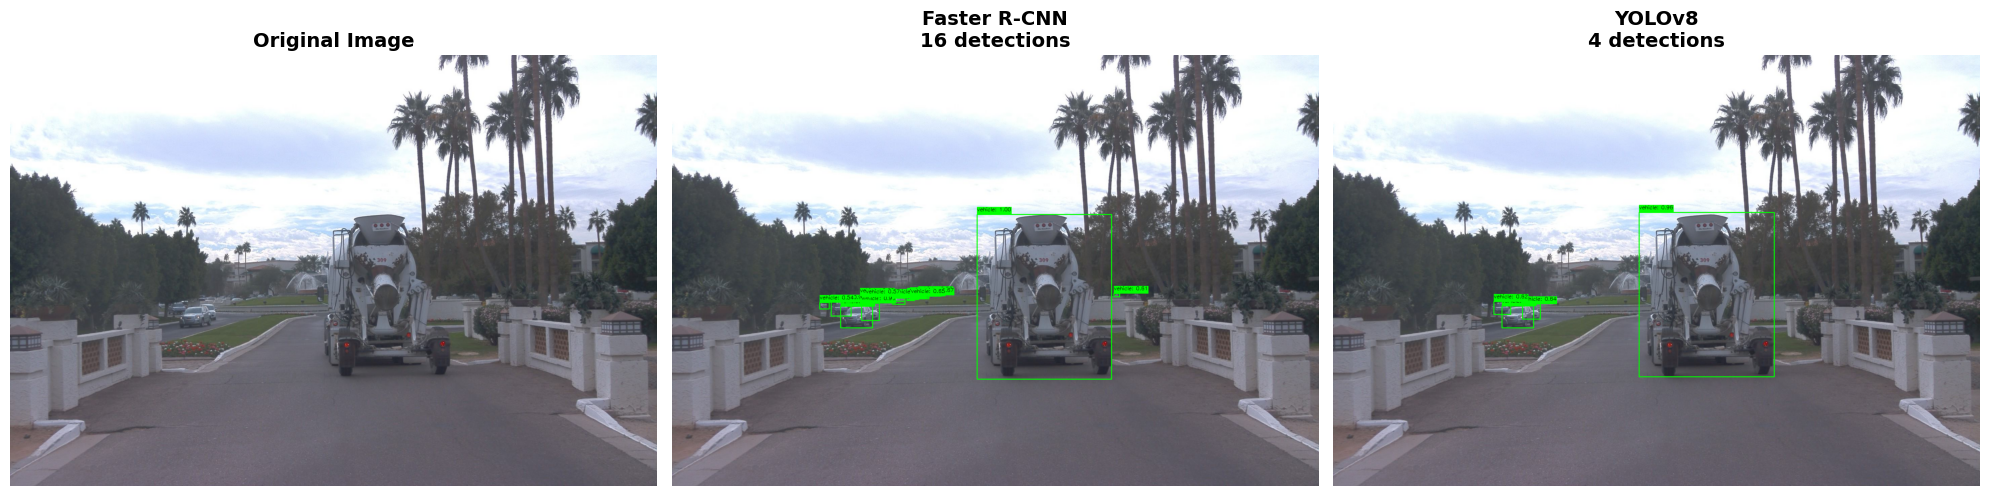


Image 2/3

Processing: waymo_dataset/images/11004685739714500220_2300_000_2320_000_1_1553640292667138.jpg
  Running Faster R-CNN...
  Running YOLOv8...
  Saved to: visualizations/waymo_comparison_2.png


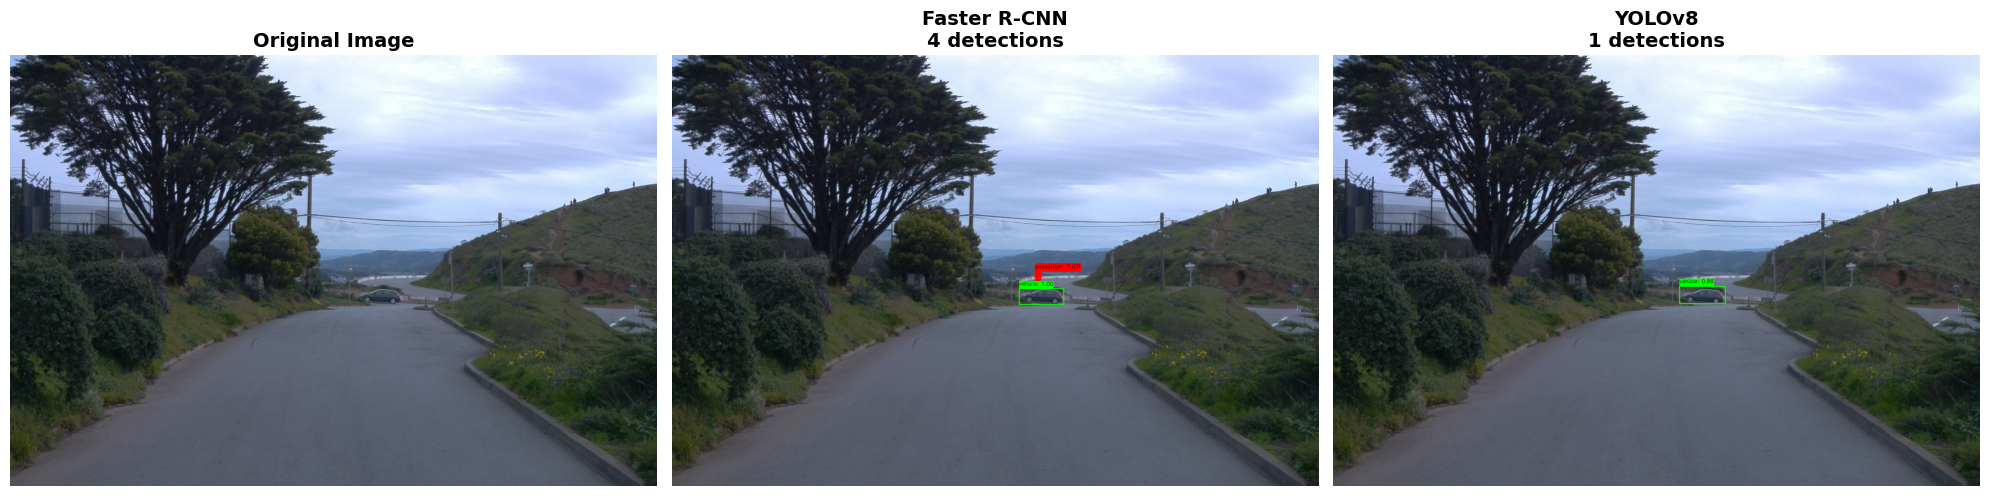


Image 3/3

Processing: waymo_dataset/images/10455472356147194054_1560_000_1580_000_1_1557335599727740.jpg
  Running Faster R-CNN...
  Running YOLOv8...
  Saved to: visualizations/waymo_comparison_3.png


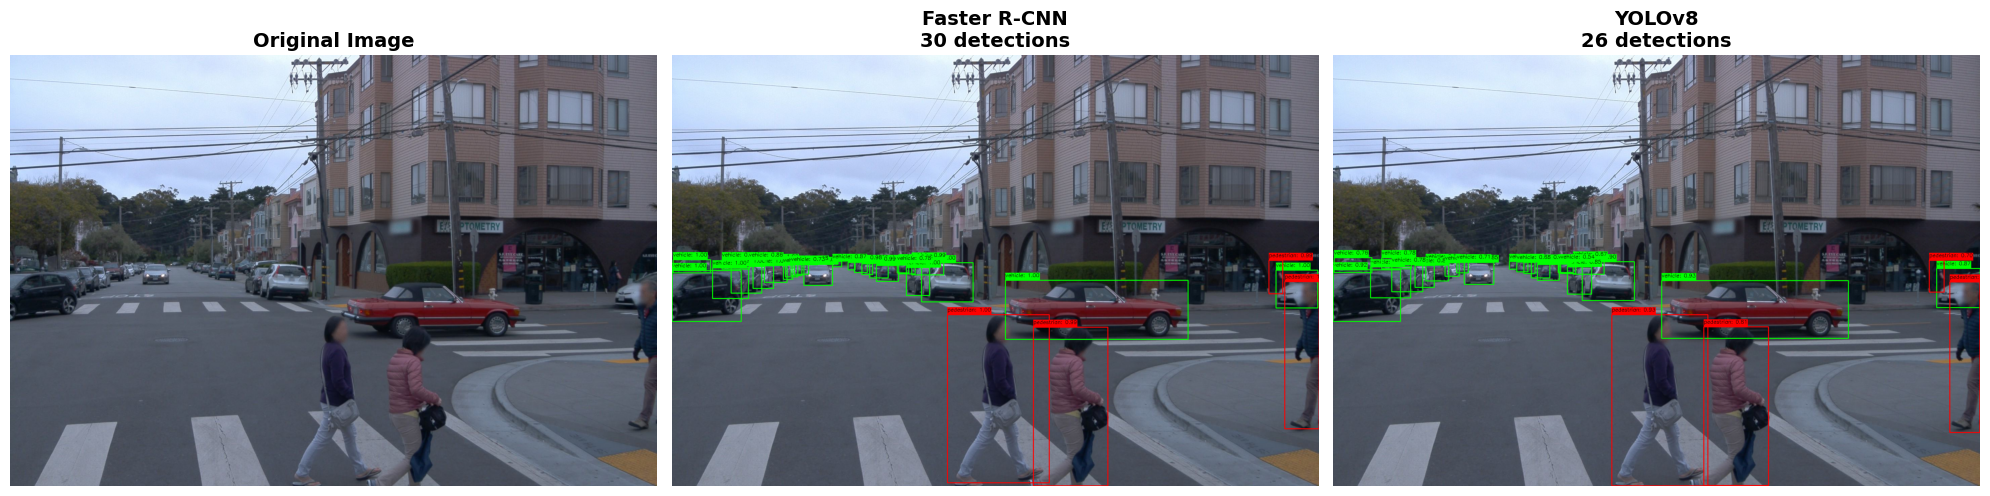


SCENARIO 2: MIXED DATASET MODEL PREDICTIONS

Image 1/3

Processing: mixed_dataset/images/waymo_11566385337103696871_5740_000_5760_000_1_1549564663199823.jpg
  Running Faster R-CNN...
  Running YOLOv8...
  Saved to: visualizations/mixed_comparison_1.png


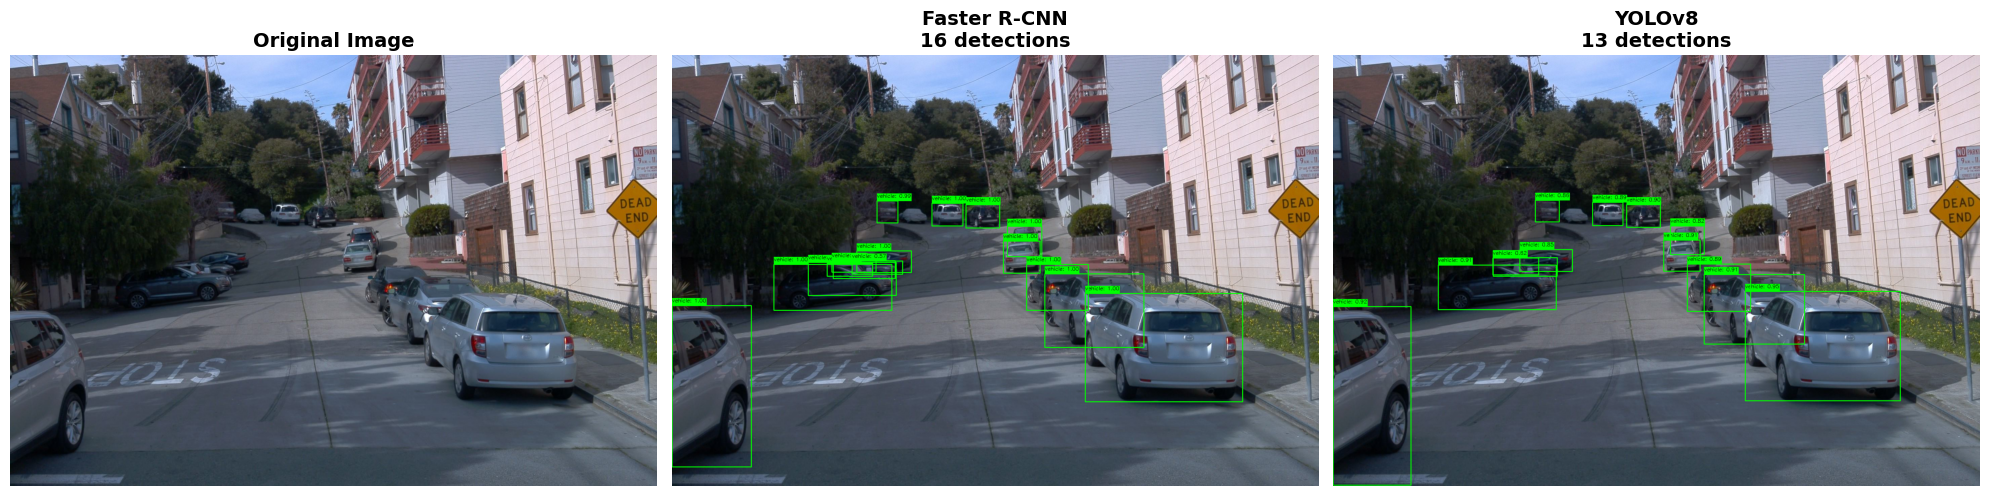


Image 2/3

Processing: mixed_dataset/images/waymo_10526338824408452410_5714_660_5734_660_1_1511380081157613.jpg
  Running Faster R-CNN...
  Running YOLOv8...
  Saved to: visualizations/mixed_comparison_2.png


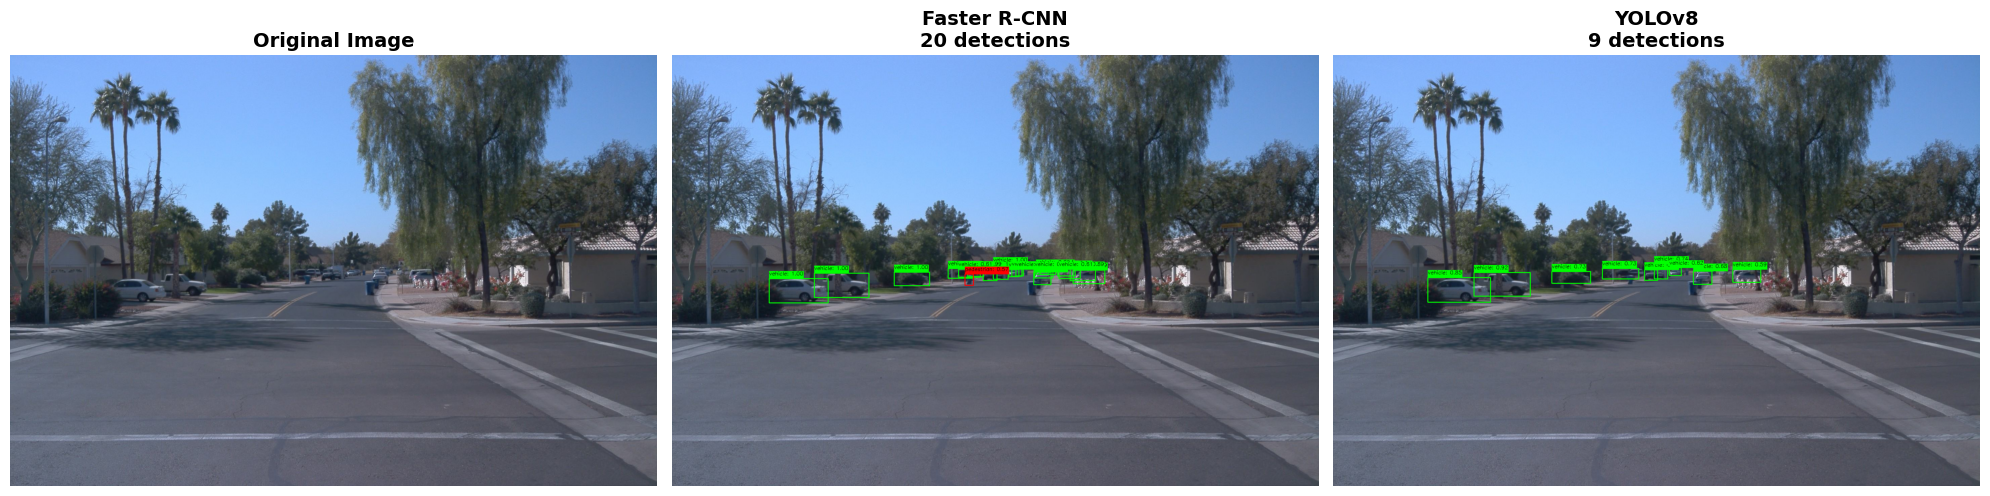


Image 3/3

Processing: mixed_dataset/images/waymo_11486225968269855324_92_000_112_000_1_1520094336385466.jpg
  Running Faster R-CNN...
  Running YOLOv8...
  Saved to: visualizations/mixed_comparison_3.png


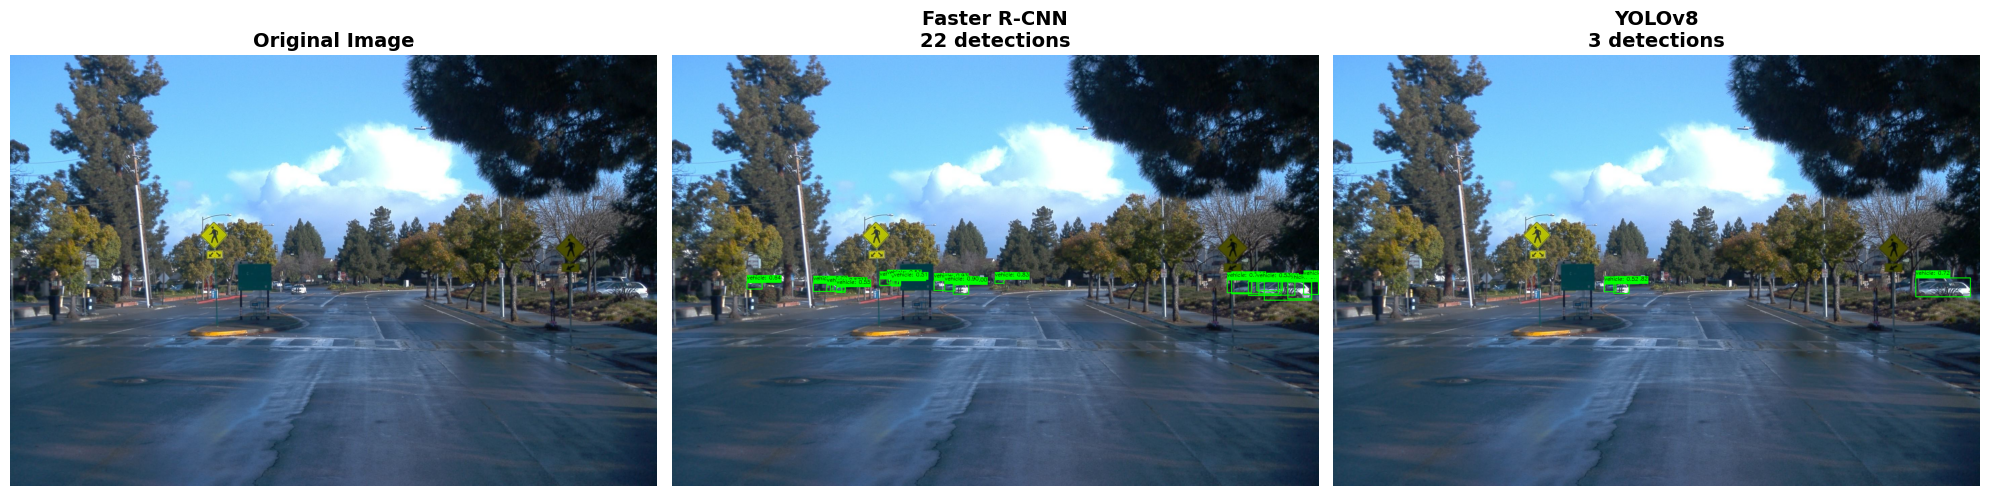


COMPLETE MODEL COMPARISON

Comparing all models on: mixed_dataset/images/waymo_11566385337103696871_5740_000_5760_000_1_1549564663199823.jpg
  Running Faster R-CNN Waymo...
  Running Faster R-CNN Mixed...
  Running YOLOv8 Waymo...
  Running YOLOv8 Mixed...
  Saved to: visualizations/all_models_comparison.png


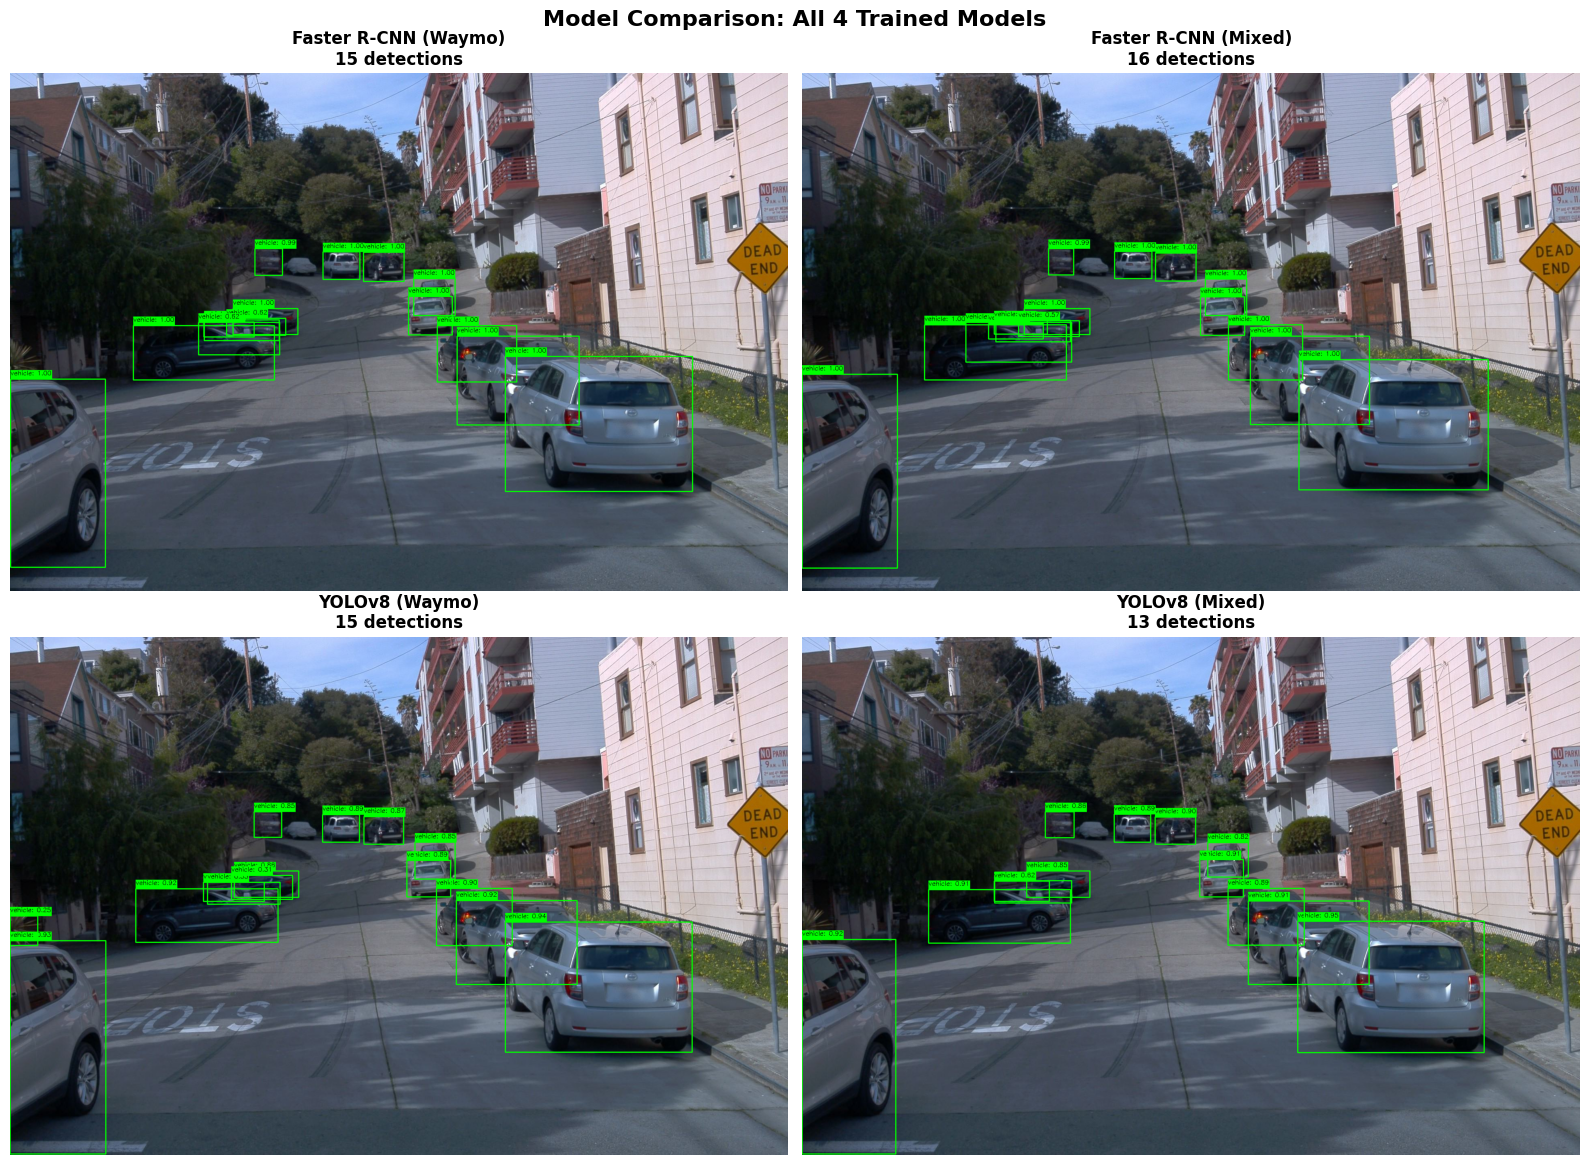


VISUALIZATION COMPLETE

All visualizations saved to 'visualizations/' directory
Files generated:
  - waymo_comparison_1.png
  - waymo_comparison_2.png
  - waymo_comparison_3.png
  - mixed_comparison_1.png
  - mixed_comparison_2.png
  - mixed_comparison_3.png
  - all_models_comparison.png


In [ ]:
CATEGORY_NAMES = {1: 'vehicle', 2: 'pedestrian', 3: 'cyclist'}
CATEGORY_COLORS = {
    1: (0, 255, 0),      # Green for vehicle
    2: (255, 0, 0),      # Blue for pedestrian
    3: (0, 255, 255),    # Yellow for cyclist
}

# Run Faster R-CNN inference on an image
def run_faster_rcnn_inference(model, image_path, confidence_threshold=0.5):

    model.eval()

    image = Image.open(image_path).convert("RGB")
    img_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(img_tensor)[0]

    boxes = predictions['boxes'][predictions['scores'] > confidence_threshold].cpu().numpy()
    labels = predictions['labels'][predictions['scores'] > confidence_threshold].cpu().numpy()
    scores = predictions['scores'][predictions['scores'] > confidence_threshold].cpu().numpy()

    return np.array(image), boxes, labels, scores

# Run YOLOv8 inference on an image
def run_yolo_inference(model_path, image_path, confidence_threshold=0.25):

    model = YOLO(model_path)
    results = model(image_path, conf=confidence_threshold, verbose=False)[0]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = results.boxes.xyxy.cpu().numpy()
    labels = (results.boxes.cls.cpu().numpy() + 1).astype(int)
    scores = results.boxes.conf.cpu().numpy()

    return image, boxes, labels, scores

# Draw bounding boxes with labels and scores
def draw_detections(image, boxes, labels, scores, category_names, category_colors):

    img = image.copy()

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box.astype(int)

        cat_name = category_names.get(label, 'unknown')
        color = category_colors.get(label, (255, 255, 255))

        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        label_text = f"{cat_name}: {score:.2f}"

        (text_width, text_height), baseline = cv2.getTextSize(
            label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1
        )
        cv2.rectangle(
            img,
            (x1, y1 - text_height - baseline - 5),
            (x1 + text_width, y1),
            color,
            -1
        )

        cv2.putText(
            img,
            label_text,
            (x1, y1 - baseline - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 0),
            1
        )

    return img

# Compare Faster R-CNN and YOLOv8 predictions side by side
def visualize_model_comparison(image_path, frcnn_model, yolo_model_path,
                               save_path=None, conf_threshold=0.5):

    print(f"\nProcessing: {image_path}")

    # Run Faster R-CNN inference
    print("  Running Faster R-CNN...")
    frcnn_img, frcnn_boxes, frcnn_labels, frcnn_scores = run_faster_rcnn_inference(
        frcnn_model, image_path, conf_threshold
    )

    # Run YOLOv8 inference
    print("  Running YOLOv8...")
    yolo_img, yolo_boxes, yolo_labels, yolo_scores = run_yolo_inference(
        yolo_model_path, image_path, conf_threshold
    )

    # Draw detections
    frcnn_result = draw_detections(
        frcnn_img, frcnn_boxes, frcnn_labels, frcnn_scores,
        CATEGORY_NAMES, CATEGORY_COLORS
    )

    yolo_result = draw_detections(
        yolo_img, yolo_boxes, yolo_labels, yolo_scores,
        CATEGORY_NAMES, CATEGORY_COLORS
    )

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Original image
    axes[0].imshow(frcnn_img)
    axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Faster R-CNN results
    axes[1].imshow(frcnn_result)
    axes[1].set_title(
        f"Faster R-CNN\n{len(frcnn_boxes)} detections",
        fontsize=14,
        fontweight='bold'
    )
    axes[1].axis('off')

    # YOLOv8 results
    axes[2].imshow(yolo_result)
    axes[2].set_title(
        f"YOLOv8\n{len(yolo_boxes)} detections",
        fontsize=14,
        fontweight='bold'
    )
    axes[2].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  Saved to: {save_path}")

    plt.show()

    return frcnn_result, yolo_result


print("="*80)
print("LOADING TRAINED MODELS")
print("="*80)

# Load Faster R-CNN models
print("\nLoading Faster R-CNN models...")

# Waymo-only model
frcnn_waymo = create_fasterrcnn_model(num_classes=4)
frcnn_waymo.load_state_dict(torch.load("fasterrcnn_waymo_epoch_10.pth"))
frcnn_waymo.to(device)
frcnn_waymo.eval()
print("  Loaded: fasterrcnn_waymo_epoch_10.pth")

# Mixed model
frcnn_mixed = create_fasterrcnn_model(num_classes=4)
frcnn_mixed.load_state_dict(torch.load("fasterrcnn_mixed_epoch_10.pth"))
frcnn_mixed.to(device)
frcnn_mixed.eval()
print("  Loaded: fasterrcnn_mixed_epoch_10.pth")

# YOLOv8 model paths
yolo_waymo_path = "runs/detect/yolo_waymo/weights/best.pt"
yolo_mixed_path = "runs/detect/yolo_mixed/weights/best.pt"

print("\nYOLOv8 model paths:")
print(f"  Waymo: {yolo_waymo_path}")
print(f"  Mixed: {yolo_mixed_path}")


# Get some test images from validation sets
import glob

# Get Waymo validation images
waymo_val_images = glob.glob("waymo_dataset/images/*.jpg")[:5]
waymo_val_images.extend(glob.glob("waymo_dataset/images/*.png")[:5])

# Get mixed validation images
mixed_val_images = glob.glob("mixed_dataset/images/waymo_*.jpg")[:3]
mixed_val_images.extend(glob.glob("mixed_dataset/images/kitti_*.png")[:3])

print(f"\nFound {len(waymo_val_images)} Waymo test images")
print(f"Found {len(mixed_val_images)} Mixed test images")


print("\n" + "="*80)
print("SCENARIO 1: WAYMO MODEL PREDICTIONS")
print("="*80)

os.makedirs("visualizations", exist_ok=True)

for i, img_path in enumerate(waymo_val_images[:3]):
    print(f"\nImage {i+1}/3")
    visualize_model_comparison(
        img_path,
        frcnn_waymo,
        yolo_waymo_path,
        save_path=f"visualizations/waymo_comparison_{i+1}.png",
        conf_threshold=0.5
    )

print("\n" + "="*80)
print("SCENARIO 2: MIXED DATASET MODEL PREDICTIONS")
print("="*80)

for i, img_path in enumerate(mixed_val_images[:3]):
    print(f"\nImage {i+1}/3")
    visualize_model_comparison(
        img_path,
        frcnn_mixed,
        yolo_mixed_path,
        save_path=f"visualizations/mixed_comparison_{i+1}.png",
        conf_threshold=0.5
    )
# Compare all 4 trained models on one image
def compare_all_models(image_path, save_path=None):


    print(f"\nComparing all models on: {image_path}")

    original = np.array(Image.open(image_path).convert("RGB"))

    print("  Running Faster R-CNN Waymo...")
    _, frcnn_waymo_boxes, frcnn_waymo_labels, frcnn_waymo_scores = \
        run_faster_rcnn_inference(frcnn_waymo, image_path, 0.5)

    print("  Running Faster R-CNN Mixed...")
    _, frcnn_mixed_boxes, frcnn_mixed_labels, frcnn_mixed_scores = \
        run_faster_rcnn_inference(frcnn_mixed, image_path, 0.5)

    print("  Running YOLOv8 Waymo...")
    _, yolo_waymo_boxes, yolo_waymo_labels, yolo_waymo_scores = \
        run_yolo_inference(yolo_waymo_path, image_path, 0.25)

    print("  Running YOLOv8 Mixed...")
    _, yolo_mixed_boxes, yolo_mixed_labels, yolo_mixed_scores = \
        run_yolo_inference(yolo_mixed_path, image_path, 0.25)

    results = [
        ("Faster R-CNN (Waymo)", frcnn_waymo_boxes, frcnn_waymo_labels, frcnn_waymo_scores),
        ("Faster R-CNN (Mixed)", frcnn_mixed_boxes, frcnn_mixed_labels, frcnn_mixed_scores),
        ("YOLOv8 (Waymo)", yolo_waymo_boxes, yolo_waymo_labels, yolo_waymo_scores),
        ("YOLOv8 (Mixed)", yolo_mixed_boxes, yolo_mixed_labels, yolo_mixed_scores),
    ]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, (title, boxes, labels, scores) in enumerate(results):
        result_img = draw_detections(
            original, boxes, labels, scores,
            CATEGORY_NAMES, CATEGORY_COLORS
        )

        axes[idx].imshow(result_img)
        axes[idx].set_title(
            f"{title}\n{len(boxes)} detections",
            fontsize=12,
            fontweight='bold'
        )
        axes[idx].axis('off')

    plt.suptitle(
        "Model Comparison: All 4 Trained Models",
        fontsize=16,
        fontweight='bold',
        y=0.98
    )
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  Saved to: {save_path}")

    plt.show()


# Run comparison on a sample image
print("\n" + "="*80)
print("COMPLETE MODEL COMPARISON")
print("="*80)

sample_image = mixed_val_images[0] if mixed_val_images else waymo_val_images[0]
compare_all_models(
    sample_image,
    save_path="visualizations/all_models_comparison.png"
)



In [ ]:

print("\n" + "="*80)
print(" PERFORMANCE SUMMARIES")
print("="*80)

print(f"\n{'Training Dataset':<25} {'Model':<20} {'Test Dataset':<15} {'mAP@0.5:0.95'}")
print("-" * 80)
print(f"{'Waymo only':<25} {'Faster R-CNN':<20} {'Waymo val':<15} {results['frcnn_waymo']:.4f}")
print(f"{'Waymo + KITTI':<25} {'Faster R-CNN':<20} {'Mixed val':<15} {results['frcnn_mixed']:.4f}")
print(f"{'Waymo only':<25} {'YOLOv8':<20} {'Waymo val':<15} {results['yolo_waymo']:.4f}")
print(f"{'Waymo + KITTI':<25} {'YOLOv8':<20} {'Mixed val':<15} {results['yolo_mixed']:.4f}")

# Save results
with open("evaluation_results_summary.json", 'w') as f:
    json.dump(results, f, indent=2)

print("\n" + "="*80)



 PERFORMANCE SUMMARIES

Training Dataset          Model                Test Dataset    mAP@0.5:0.95
--------------------------------------------------------------------------------
Waymo only                Faster R-CNN         Waymo val       0.3592
Waymo + KITTI             Faster R-CNN         Mixed val       0.4109
Waymo only                YOLOv8               Waymo val       0.3187
Waymo + KITTI             YOLOv8               Mixed val       0.3870

